<a href="https://colab.research.google.com/github/FlorPrandi/nuclio-git-course/blob/main/1121_SupML_%7BFlorencia_Prandi%7D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Microsoft Malware Prediction**

## Import libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [ ]:
from sklearn import preprocessing

In [ ]:
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importar los datos

In [ ]:
# Importamos el csv ya que desde la url no es posible descargarlo

pd.read_csv("/content/drive/MyDrive/Nuclio/Microsoft Malware Prediction/sample_mmp.csv", index_col=[0])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (29,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
8427007,f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,8,85219.0,NaN,205.0,172,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,1443.0,275891.0,4.0,5.0,...,HDD,952838.0,0,8192.0,AllinOne,23.0,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,27.0,120,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,19951.0,0,NaN,0.0,0,0,0.0,0.0,11.0,1
8829090,fd5ba6f5b75325ec0423a6c67cc75942,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,129,54198.0,NaN,126.0,124,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2102.0,248850.0,4.0,5.0,...,HDD,457600.0,0,8192.0,Notebook,13.2,1280.0,720.0,Mobile,lion,0.000000e+00,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,18.0,72,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,486.0,48753.0,0,0.0,0.0,0,0,0.0,1.0,3.0,0
2731904,4e628391e7cc7c482fb3286f486dbd25,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,0,7.0,0,NaN,46781.0,2.0,1.0,1,149,122689.0,27.0,181.0,56,windows10,x64,10.0.0.0,10586,768,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Home,1.0,0,NaN,0.0,74.0,RequireAdmin,1.0,1.0,Convertible,Windows.Desktop,2206.0,238234.0,4.0,5.0,...,SSD,221251.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,lion,0.000000e+00,10.0.10586.1176,amd64,th2_release_sec,10586,1176,Core,CORE,Update,24.0,109,Notify,0,IS_GENUINE,Retail,NaN,0.0,Retail,0.0,554.0,33111.0,1,0.0,0.0,1,1,0.0,0.0,15.0,0
1359513,270a2e9d028144a4df12a9e3da79fba5,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,164,114587.0,27.0,205.0,172,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,525.0,265410.0,8.0,5.0,...,SSD,228321.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,5.770000e+02,10.0.17134.286,amd64,rs4_release,17134,286,Core,CORE,IBSClean,27.0,120,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,48473.0,1,NaN,0.0,0,0

In [ ]:
# Creamos el DataFrame a partir del .csv descargado

df = pd.read_csv("/content/drive/MyDrive/Nuclio/Microsoft Malware Prediction/sample_mmp.csv", index_col=[0])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (29,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## ML CHECKLIST

#### 2.1 Análisis univariante de los datos



##### Con el .info() podemos ver que nuestro dataset tiene un total de 83 columnas, distribuidos en tres tipos de datos (integers, floats y objects), un total de 50.000 registros, y un consumo de la RAM de 320.4+ MB. 
##### Por último ya podemos observar que varias columnas tienen valores nulos a revisar.

#### 2.1.1 Tamaño del Dataset

In [ ]:
# Primer punto de la checklist de ML

df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 8427007 to 4295573
Columns: 83 entries, MachineIdentifier to HasDetections
dtypes: float64(36), int64(17), object(30)
memory usage: 320.4+ MB


In [ ]:
# Hacemos un len() para corroborar el tamaño del dataset, numero que tendremos que tener en cuenta para posibles JOINs, de manera de asegurarnos de no perder información 

len(df)

500000

In [ ]:
# Con el shape corroboramos el valor de columnas y filas, también importante al momento de posibles joins

df.shape

(500000, 83)

#### 2.1.2 Visualización directa de los datos

In [ ]:
# Hacemos un .head() para analizar en detalle los datos de nuestro df

df.head(1)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
8427007,f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,8,85219.0,NaN,205.0,172,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,1443.0,275891.0,4.0,5.0,...,HDD,952838.0,0,8192.0,AllinOne,23.0,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,27.0,120,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,19951.0,0,NaN,0.0,0,0,0.0,0.0,11.0,1


In [ ]:
# A simple vista pareciera que el indice no sigue un orden, vamos a hacer un reset_index para corregirlo

df.reset_index(drop = True, inplace = True)

In [ ]:
# Corroboramos que ahora el indice es correcto

df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,8,85219.0,NaN,205.0,172,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,1443.0,275891.0,4.0,5.0,...,HDD,952838.0,0,8192.0,AllinOne,23.0,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,27.0,120,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,19951.0,0,NaN,0.0,0,0,0.0,0.0,11.0,1
1,fd5ba6f5b75325ec0423a6c67cc75942,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,129,54198.0,NaN,126.0,124,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2102.0,248850.0,4.0,5.0,...,HDD,457600.0,0,8192.0,Notebook,13.2,1280.0,720.0,Mobile,lion,0.000000e+00,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,18.0,72,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,486.0,48753.0,0,0.0,0.0,0,0,0.0,1.0,3.0,0
2,4e628391e7cc7c482fb3286f486dbd25,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,0,7.0,0,NaN,46781.0,2.0,1.0,1,149,122689.0,27.0,181.0,56,windows10,x64,10.0.0.0,10586,768,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Home,1.0,0,NaN,0.0,74.0,RequireAdmin,1.0,1.0,Convertible,Windows.Desktop,2206.0,238234.0,4.0,5.0,...,SSD,221251.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,lion,0.000000e+00,10.0.10586.1176,amd64,th2_release_sec,10586,1176,Core,CORE,Update,24.0,109,Notify,0,IS_GENUINE,Retail,NaN,0.0,Retail,0.0,554.0,33111.0,1,0.0,0.0,1,1,0.0,0.0,15.0,0
3,270a2e9d028144a4df12a9e3da79fba5,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,164,114587.0,27.0,205.0,172,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,525.0,265410.0,8.0,5.0,...,SSD,228321.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,5.770000e+02,10.0.17134.286,amd64,rs4_release,17134,286,Core,CORE,IBSClean,27.0,120,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,48473.0,1,NaN,0.0,0,0,0.0,0.0,15.0,1
4,06ca8f

In [ ]:
# También podemos hacer un .columns para ver todos los nombres de las columnas a analizar

df.columns

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
       'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform',
       'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
       'OsBuildLab', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'PuaMode',
       'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
       'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_ProcessorClass',
       'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
       'Census_

Vamos a analizar en detalle cuáles son las variables de nuestro DataFrame

A continuación se incluye la descripción de las variables:

* **MachineIdentifier**: ID de máquina individual.
* **ProductName**: Nombre del software antivirus.
* **EngineVersion**: Versión del motor.
* **AppVersion**: Version de aplicacion.
* **AvSigVersion**: Versión de firma antivirus.
* **IsBeta**: Si se encuentra todavía en la fase de desarrollo y no en la versión final.
* **RtpStateBitfield**: Real-Time Protection / Real-time Transport Protocol
??????
* **IsSxsPassiveMode**: Modo de funcionamiento activo/pasivo del software antivirus. Si existe otro antivirus primario de terceros en el sistema, el Defender ingresa al modo Pasivo. El modo pasivo obviamente ofrece una funcionalidad reducida, y tendrá una mayor prevalencia de malware.
* **DefaultBrowsersIdentifier**: ID para el navegador predeterminado de la máquina.
* **AVProductStatesIdentifier**: ID para la configuración específica del software antivirus de un usuario.
* **AVProductsInstalled**: El número de productos antivirus instalados.
* **AVProductsEnabled**: El número de productos antivirus habilitados.
* **HasTpm**: Trusted Platform Módule es un chip físico que se encuentra en las placas base de nuestros ordenadores, pero es un chip pasivo que se encuentra desactivado de fábrica y solo si el usuario quiere, puede elegir activarlo. En sí es un criptoprocesador seguro capaz de almacenar claves de cifrado con las que proteger nuestra información.
* **CountryIdentifier**: ID del país en el que se encuentra la máquina.
* **CityIdentifier**: ID de la ciudad en la que se encuentra la máquina.
* **OrganizationIdentifier**: ID de la organización a la que pertenece la máquina.
* **GeoNameIdentifier**: Columna de ID para las 292 regiones geográficas en las que se encuentra una máquina.
* **LocaleEnglishNameIdentifier**: Nombre en inglés del ID de configuración regional del usuario actual.
* **Platform**: Sistema operativo de la máquina.
* **Processor**: Esta es la arquitectura de proceso del sistema operativo instalado.
* **OsVer**: Versión del sistema operativo actual.
* **OsBuild**: Compilación del sistema operativo actual.
* **OsSuite**: Conjunto de productos para el sistema operativo actual.
* **OsPlatformSubRelease**: Devuelve la versión secundaria de OS Platform.
* **OsBuildLab**: Lab de compilación que generó el sistema operativo actual
* **SkuEdition**: El objetivo de esta función es utilizar el Tipo de producto definido en MSDN para asignar un nombre de 'Edición de SKU' que sea útil en los informes de población (Home, Pro, Enterprise, etc.).
* **IsProtected**: Devuelve si una máquina está protegida.: A. VERDADERO si hay al menos un producto antivirus activo y actualizado ejecutándose en esta máquina. B. FALSO si no hay ningún producto AV activo en esta máquina, o si el AV está activo, pero no recibe las últimas actualizaciones. C. nulo si no hay productos antivirus en el informe.
* **AutoSampleOptIn**: ?
* **PuaMode**: Modo Pua habilitado desde el servicio. "La función de protección de aplicaciones potencialmente no deseadas (PUA) en Windows Defender Antivirus puede identificar y bloquear las PUA para que no se descarguen e instalen en los puntos finales de su red.
PUA también puede referirse a aplicaciones que se considera que tienen mala reputación.
* **SMode**: Este campo se establece en verdadero cuando se sabe que el dispositivo está en "Modo S", como en el modo S de Windows 10, donde solo se pueden instalar aplicaciones de Microsoft Store.
* **IeVerIdentifier**: Obtiene qué versión de Internet Explorer se está ejecutando en este dispositivo.
* **SmartScreen**: Windows Defender SmartScreen ayuda a proteger a sus empleados si intentan visitar sitios previamente informados como sitios web de phishing o malware, o si un empleado intenta descargar archivos potencialmente maliciosos.
* **Firewall**: Este atributo es verdadero (1) para Windows 8.1 y superior si el firewall de Windows está habilitado.
* **UacLuaenable**: Este atributo informa si el tipo de usuario "administrador en modo de aprobación de administrador" está deshabilitado o habilitado en UAC.
* **Census_MDC2FormFactor**: Hardware utilizado (Ejemplos: Smartphone, Tableta pequeña, etc.)
* **Census_DeviceFamily**: Indica el tipo de dispositivo para el que está destinada una edición del sistema operativo.
* **Census_OEMNameIdentifier**: Tradicionalmente, un fabricante de equipos originales (OEM) se define como una empresa cuyos productos se utilizan como componentes en los productos de otra empresa, que luego vende el artículo terminado a los usuarios.
* **Census_OEMModelIdentifier**: NA
* **Census_ProcessorCoreCount**: Número de núcleos lógicos en el procesador.
* **Census_ProcessorManufacturerIdentifier**: Identificador del fabricante del procesador.
* **Census_ProcessorModelIdentifier**: Identificador de modelo de procesador.
* **Census_ProcessorClass**: Una clasificación de los procesadores en alto/medio/bajo. 
* **Census_PrimaryDiskTotalCapacity**: Cantidad de espacio en disco en el disco principal de la máquina en MB.
* **Census_PrimaryDiskTypeName**: Nombre descriptivo del tipo de disco principal
* **Census_SystemVolumeTotalCapacity**: El tamaño de la partición en la que está instalado el volumen del sistema en MB.
* **Census_HasOpticalDiskDrive**: Verdadero indica que la máquina tiene una unidad de disco óptico (CD/DVD). Si tiene puede presumirse que son equipos antiguos y puede correlacionarse con tasas de malware más altas.
* **Census_TotalPhysicalRAM**: Recupera la RAM física en MB.
* **Census_ChassisTypeName**: Recupera una representación numérica de qué tipo de chasis tiene el equipo.
* **Census_InternalPrimaryDiagonalDisplaySizeInInches**: Recupera la longitud diagonal física en pulgadas de la pantalla principal.
* **Census_InternalPrimaryDisplayResolutionHorizontal**: Recupera el número de píxeles en la dirección horizontal de la pantalla interna.
* **Census_InternalPrimaryDisplayResolutionVertical**: Recupera el número de píxeles en la dirección vertical de la pantalla interna.
* **Census_PowerPlatformRoleName**: Indica el perfil de administración de energía preferido por el OEM. Este valor ayuda a identificar el factor de forma básico del dispositivo.
* **Census_InternalBatteryType**: Modelo de bateria interna.
* **Census_InternalBatteryNumberOfCharges**: Suponiendo que este sea el número de ciclos de batería.
* **Census_OSVersion**: Versión de sistema operativo numérico.
* **Census_OSArchitecture**: Arquitectura en la que se basa el sistema operativo.
* **Census_OSBranch**: Rama del sistema operativo extraída de OsVersionFull.
* **Census_OSBuildNumber**: Número de compilación del sistema operativo extraído de OsVersionFull.
* **Census_OSBuildRevision**: Revisión de compilación del sistema operativo extraída de OsVersionFull.
* **Census_OSEdition**: Edición del sistema operativo actual.
* **Census_OSSkuName**: Nombre descriptivo de la edición del sistema operativo.
* **Census_OSInstallTypeName**: Descripción amigable de qué instalación se usó en la máquina.
* **Census_OSInstallLanguageIdentifier**: Lenguaje del sistema operativo.
* **Census_OSUILocaleIdentifier**: Un conjunto de parámetros que define el idioma del usuario, la región y cualquier preferencia de variante especial que el usuario quiera ver en su interfaz de usuario.
* **Census_OSWUAutoUpdateOptionsName**: Nombre descriptivo de la configuración de actualización automática de WindowsUpdate en la máquina.
* **Census_IsPortableOperatingSystem**: Indica si el sistema operativo se inicia y ejecuta a través de Windows-To-Go en una memoria USB.
* **Census_GenuineStateName**: Nombre descriptivo de OSGenuineStateID.
* **Census_ActivationChannel**: Clave de licencia minorista o clave de licencia por volumen para una máquina.
* **Census_IsFlightingInternal**: 'Flighting' en el contexto de Windows Defender significa hacer que las nuevas funciones de desarrollo estén disponibles lo antes posible, durante el ciclo de desarrollo.
* **Census_IsFlightsDisabled**: Indica si la máquina está participando en tramos.
* **Census_FlightRing**: NA
* **Census_ThresholdOptIn**: NA
* **Census_FirmwareManufacturerIdentifier**: identificadores de fabricante de firmware.
* **Census_FirmwareVersionIdentifier**: versión identificadores de fabricante de firmware.

* **Census_IsSecureBootEnabled**: Indica si el modo de arranque seguro está habilitado.

* **Census_IsWIMBootEnabled**: NA.
* **Census_IsVirtualDevice**: Identifica una máquina virtual.
* **Census_IsTouchEnabled**: Si es o no un dispositivo táctil.
* **Census_IsPenCapable**: Si es o no un dispositivo capaz de entrada de lápiz.
* **Census_IsAlwaysOnAlwaysConnectedCapable**: Recupera información sobre si la batería permite que el dispositivo esté siempre conectado.
* **Wdft_IsGamer**: Indica si el dispositivo es un dispositivo de jugador o no en función de su combinación de hardware.
* **Wdft_RegionIdentifier**: NA
* **HasDetections**: Nuestro TARGET, si la máquina ha sido infectada o no.

#### 2.1.3 Tipo de atributos disponibles



In [ ]:
# Para tener controlado el tipo de atributos que cuenta nuestro df podemos hacer un .info(verbose = True), que es la versión larga del metodo

df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  500000 non-null  object 
 1   ProductName                                        500000 non-null  object 
 2   EngineVersion                                      500000 non-null  object 
 3   AppVersion                                         500000 non-null  object 
 4   AvSigVersion                                       500000 non-null  object 
 5   IsBeta                                             500000 non-null  int64  
 6   RtpStateBitfield                                   498168 non-null  float64
 7   IsSxsPassiveMode                                   500000 non-null  int64  
 8   DefaultBrowsersIdentifier                          24061 non-null   float6

#### 2.1.4 Estadísticos descriptivos

In [ ]:
# La manera más fácil de realizar este paso es usando el .describe().T, de esta forma veremos solo las numéricas

df.describe().T

,count,mean,std,min,25%,50%,75%,max
IsBeta,500000.0,2.000000e-06,1.414214e-03,0.0,0.00,0.0,0.000000e+00,1.000000e+00
RtpStateBitfield,498168.0,6.846207e+00,1.023049e+00,0.0,7.00,7.0,7.000000e+00,3.500000e+01
IsSxsPassiveMode,500000.0,1.724200e-02,1.301720e-01,0.0,0.00,0.0,0.000000e+00,1.000000e+00
DefaultBrowsersIdentifier,24061.0,1.652825e+03,1.004754e+03,1.0,788.00,1632.0,2.381000e+03,3.209000e+03
AVProductStatesIdentifier,498062.0,4.785091e+04,1.402309e+04,3.0,49480.00,53447.0,5.344700e+04,7.049200e+04
AVProductsInstalled,498062.0,1.326763e+00,5.229999e-01,1.0,1.00,1.0,2.000000e+00,5.000000e+00
AVProductsEnabled,498062.0,1.020714e+00,1.666080e-01,0.0,1.00,1.0,1.000000e+00,4.000000e+00
HasTpm,500000.0,9.878160e-01,1.097068e-01,0.0,1.00,1.0,1.000000e+00,1.000000e+00
CountryIdentifier,500000.0,1.080375e+02,6.306854e+01,1.0,51.00,97.0,1.620000e+02,2.220000e+02
CityIdentifier,481760.0,8.127165e+04,4.898513e+04,7.0,36825.00,82373.0,1.239395e+05,1.679580e+05


In [ ]:
# Para ver las variables categóricas podemos hacer un .describe() incluyendo las de tipo object 

df.describe(include=['object']).T

,count,unique,top,freq
MachineIdentifier,500000,500000,f1cd864e97bae82bdf96523e1a539121,1
ProductName,500000,3,win8defender,494604
EngineVersion,500000,53,1.1.15200.1,216491
AppVersion,500000,95,4.18.1807.18075,288809
AvSigVersion,500000,6455,1.273.1420.0,5771
Platform,500000,4,windows10,483048
Processor,500000,3,x64,454423
OsVer,500000,21,10.0.0.0,483830
OsPlatformSubRelease,500000,9,rs4,220779
OsBuildLab,499999,453,17134.1.amd64fre.rs4_release.180410-1804,206436


#### 2.1.5 Número de valores nulos


In [ ]:
# Vamos a revisar los nulos del DataFrame distinguiendo entre variables numericas y categoricas
# Vemos que las variables numéricas cuentan con muchos nulos, mientras que las categóricas tienen un nivel más bajo de nulos
df.select_dtypes(include=['number']).isnull().sum()

IsBeta                                                    0
RtpStateBitfield                                       1832
IsSxsPassiveMode                                          0
DefaultBrowsersIdentifier                            475939
AVProductStatesIdentifier                              1938
AVProductsInstalled                                    1938
AVProductsEnabled                                      1938
HasTpm                                                    0
CountryIdentifier                                         0
CityIdentifier                                        18240
OrganizationIdentifier                               154563
GeoNameIdentifier                                        16
LocaleEnglishNameIdentifier                               0
OsBuild                                                   0
OsSuite                                                   0
IsProtected                                            1926
AutoSampleOptIn                         

In [ ]:
df.select_dtypes(include=['object']).isnull().sum()

MachineIdentifier                        0
ProductName                              0
EngineVersion                            0
AppVersion                               0
AvSigVersion                             0
Platform                                 0
Processor                                0
OsVer                                    0
OsPlatformSubRelease                     0
OsBuildLab                               1
SkuEdition                               0
PuaMode                             499874
SmartScreen                         178596
Census_MDC2FormFactor                    0
Census_DeviceFamily                      0
Census_ProcessorClass               497918
Census_PrimaryDiskTypeName             709
Census_ChassisTypeName                  37
Census_PowerPlatformRoleName             2
Census_InternalBatteryType          355603
Census_OSVersion                         0
Census_OSArchitecture                    0
Census_OSBranch                          0
Census_OSEd

#### 2.1.6 Distribución de los valores del target

##### Tenemos que conocer la distribución del TARGET, ya que es un aspecto clave en problemas de clasificación supervisada.

In [ ]:
# Para mayor comodidad vamos a generar una variable que contenga el TARGET

TARGET = 'HasDetections'

In [ ]:
# Hacemos un value_counts() del target, con dropna = False para ver si hay valores nulos en el TARGET

df[TARGET].value_counts(dropna = False)

0    250047
1    249953
Name: HasDetections, dtype: int64

In [ ]:
# Chequeamos que no hay nulos en el TARGET

df[TARGET].isnull().sum()

0

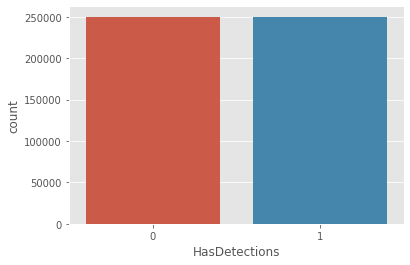

In [ ]:
# Podemos hacer un gráfico rápido para ver la distribución del TARGET, a simple vista podemos ver que el dataset se encuentra balanceado
sns.countplot(data=df, x=TARGET)

##### Vemos que nuestro TARGET contiene 2 valores númericos:


*   HasDetections = 1
*   HasDetections = 0

Vamos a seguir analizando el TARGET con un count(), sum() para ver cuántos equipos han sido infectados, mean() para ver de media cuántos equipos se han infectado.



In [ ]:
df[TARGET].count()

500000

In [ ]:
df[TARGET].sum()

249953

In [ ]:
# Este % deberemos recordarlo para corroborar la predicción de nuestro modelo

df[TARGET].mean()*100

49.9906

In [ ]:
# Una forma más rápida es hacer un .describe(), aquí corroboramos la media, % importante a tener en mente durante este proyecto

df[TARGET].describe()

count    500000.000000
mean          0.499906
std           0.500000
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: HasDetections, dtype: float64

#### 2.1.7 - 2.1.9 Indentificación de outliers / Identificación de datos erróneos / Correlación de variables con el TARGET

#### 2.2 - Analisis Multivariante de los datos

#### 3.1 - Limpieza de atributos

In [ ]:
# Vamos a crear una tabla con la info de todas las variables para ir haciendo el análisis de todas las columnas e identificar qué tratamiento le aplicamos
df_description = df.describe(include = 'all').T

In [ ]:
from google.colab import files
df_description.to_excel('df_description_MMP.xlsx')
files.download('df_description_MMP.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Antes de comenzar con el análisis de nuestro dataset crearé dos funciones básicas para crear una PIVOT TABLE y por otro lado GRAFICOS
# PIVOT TABLE
def pivotTable_func(column, dataframe):
  return pd.pivot_table(data = dataframe, index = column, values = TARGET, aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

In [ ]:
# Agrupar valores minoritarios categoricas

def set_Others(dataframe, column, num_values):
  top_values = dataframe[column].value_counts().head(num_values)
  top_values_list = top_values.index.to_list()
  top_values_list.append('Others')
  dataframe[column] = pd.Categorical(dataframe[column], categories = top_values_list)
  return dataframe[column].fillna('Others')

In [ ]:
# Agrupar valores minoritarios numericas

def set_Others_num(dataframe, column, num_values):
  top_values = dataframe[column].value_counts().head(num_values)
  top_values_list = top_values.index.to_list()
  top_values_list.append(-1)
  dataframe[column] = pd.Categorical(dataframe[column], categories = top_values_list)
  return dataframe[column].fillna(-1)

In [ ]:
# Funcion para saber cuantos grupos tengo que crear en una variable, dependiendo la cantidad de las etiquetas (<1%)

def get_num_values(df, column):
 num_values = 0
 pct_acumulado = 0
 for value in df[column].value_counts(): 
  pct_acumulado += value / df[column].value_counts().sum()*100
  if value / df[column].value_counts().sum()*100 < 1:
    return num_values
  num_values+= 1

#####**MachineIdentifier**

###### MachineIdentifier tiene 500.000 valores únicos, podemos utilizar el mismo como indice de nuestro dataset

In [ ]:
df['MachineIdentifier'].describe()

count                               500000
unique                              500000
top       f1cd864e97bae82bdf96523e1a539121
freq                                     1
Name: MachineIdentifier, dtype: object

In [ ]:
# Seteamos el MachineIdentifier como index de nuestro df

df.set_index('MachineIdentifier', inplace = True)

#####**ProductName**

###### Product Name tiene 3 valores distintos, pero vemos que 'mseprerelease' tiene 1 solo registro, pero al encontrarnos en un Decision Tree dejaremos esta variable como está, ya que el DT decidirá si es importante o no dicha variable

In [ ]:
df['ProductName'].describe()

count           500000
unique               3
top       win8defender
freq            494604
Name: ProductName, dtype: object

In [ ]:
df['ProductName'].value_counts(dropna = False)

win8defender     494604
mse                5395
mseprerelease         1
Name: ProductName, dtype: int64

In [ ]:
df['ProductName'].replace('mseprerelease', 'mse', inplace=True)

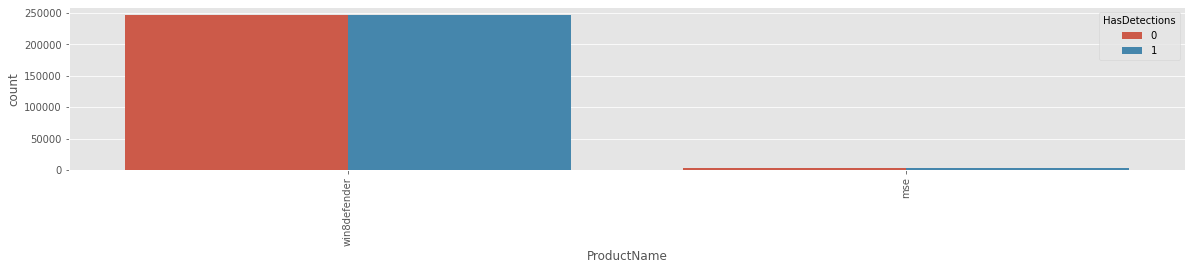

In [ ]:
plt.figure(figsize=[20,3])
plt.xticks(rotation=90)
sns.countplot(data=df, x='ProductName', hue=TARGET)

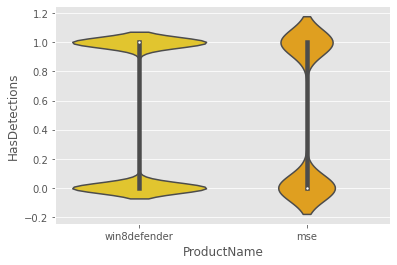

In [ ]:
# Hacemos gráfico de violines para corroborar la distribución, vemos que en ambos casos la parte más amplia las tenemos 1 y 0, entiendo que esto es así por lo balanceado que está el dataset
# el mse se muestra más angosto por la menor cantidad de registros en este atributo

sns.violinplot(x="ProductName",y=TARGET, data=df, palette="Wistia")

In [ ]:
# Podemos ver que el TARGET se encuentra bastante balanceado, pero viendo el # de registros, podemos confiarnos más de la media que nos muestra el atributo de win8defender
pivotTable_func('ProductName', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
ProductName,,,
win8defender,494604,247367,0.500131
mse,5396,2586,0.479244


#####**EngineVersion**

###### EngineVersion tiene 53 valores distintos, vemos que no hay nulos. También podemos identificar que hay muchos minoritarios, pero aquí como se trata de una variable de versiones, podemos entender que hay un orden intrínseco, por lo que la convertiremos a numérica solamente

In [ ]:
df['EngineVersion'].describe()

count          500000
unique             53
top       1.1.15200.1
freq           216491
Name: EngineVersion, dtype: object

In [ ]:
df['EngineVersion'].value_counts(dropna = False)

1.1.15200.1    216491
1.1.15100.1    205494
1.1.15000.2     14752
1.1.14901.4     11984
1.1.14600.4      9005
1.1.14800.3      7548
1.1.15300.6      6769
1.1.14104.0      5240
1.1.15300.5      3883
1.1.13504.0      3876
1.1.14700.5      2593
1.1.14500.5      2591
1.1.14405.2      1972
1.1.14306.0      1329
1.1.14202.0       840
1.1.14003.0       804
1.1.13303.0       516
1.1.13903.0       515
1.1.13804.0       513
1.1.13407.0       479
1.1.13601.0       420
1.1.12902.0       321
1.1.14305.0       270
1.1.13701.0       255
1.1.13704.0       255
1.1.13202.0       245
1.1.13103.0       235
1.1.13000.0       220
1.1.15000.1       138
1.1.12805.0       115
1.1.14901.3        71
1.1.14700.4        65
1.1.14700.3        61
1.1.14800.1        51
1.1.14500.2        19
1.1.14201.0        11
1.1.14303.0        10
1.1.12101.0         7
1.1.14103.0         5
1.1.12804.0         4
1.1.13802.0         4
1.1.13902.0         4
1.1.13803.0         3
1.1.12603.0         3
1.1.11701.0         3
1.1.14001.

In [ ]:
# Corroboramos el % de los registros sobre el total de nuestro dataset para poder agrupar por valores minoritarios

(df['EngineVersion'].value_counts(dropna = False) / df['EngineVersion'].size)*100

1.1.15200.1    43.2982
1.1.15100.1    41.0988
1.1.15000.2     2.9504
1.1.14901.4     2.3968
1.1.14600.4     1.8010
1.1.14800.3     1.5096
1.1.15300.6     1.3538
1.1.14104.0     1.0480
1.1.15300.5     0.7766
1.1.13504.0     0.7752
1.1.14700.5     0.5186
1.1.14500.5     0.5182
1.1.14405.2     0.3944
1.1.14306.0     0.2658
1.1.14202.0     0.1680
1.1.14003.0     0.1608
1.1.13303.0     0.1032
1.1.13903.0     0.1030
1.1.13804.0     0.1026
1.1.13407.0     0.0958
1.1.13601.0     0.0840
1.1.12902.0     0.0642
1.1.14305.0     0.0540
1.1.13701.0     0.0510
1.1.13704.0     0.0510
1.1.13202.0     0.0490
1.1.13103.0     0.0470
1.1.13000.0     0.0440
1.1.15000.1     0.0276
1.1.12805.0     0.0230
1.1.14901.3     0.0142
1.1.14700.4     0.0130
1.1.14700.3     0.0122
1.1.14800.1     0.0102
1.1.14500.2     0.0038
1.1.14201.0     0.0022
1.1.14303.0     0.0020
1.1.12101.0     0.0014
1.1.14103.0     0.0010
1.1.12804.0     0.0008
1.1.13802.0     0.0008
1.1.13902.0     0.0008
1.1.13803.0     0.0006
1.1.12603.0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]), <a list of 53 Text major ticklabel objects>)

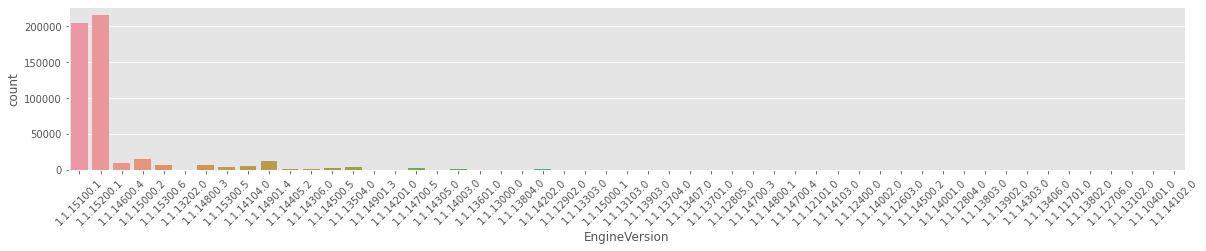

In [ ]:
# El histograma también nos sirve para poder ver de forma más visual todos los valores que tenemos con pocos registros
plt.figure(figsize=[20,3])
sns.countplot(df['EngineVersion'])
plt.xticks(rotation=45)

In [ ]:
df['EngineVersion'] = df['EngineVersion'].str.replace(".", "").astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
pivotTable_func('EngineVersion', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
EngineVersion,,,
11131020,1,1,1.000000
11124000,1,1,1.000000
11134060,1,1,1.000000
11138020,4,3,0.750000
11117010,3,2,0.666667
11121010,7,4,0.571429
11151001,205494,113557,0.552605
11153005,3883,2025,0.521504


#####**AppVersion**

###### AppVersion tiene 95 valores distintos, vemos que no hay nulos. También podemos identificar que hay muchos minoritarios, pero aquí como se trata de una variable de versiones, podemos entender que hay un orden intrínseco, por lo que la convertiremos a numérica solamente

In [ ]:
df['AppVersion'].describe()

count              500000
unique                 95
top       4.18.1807.18075
freq               288809
Name: AppVersion, dtype: object

In [ ]:
df['AppVersion'].value_counts() 

4.18.1807.18075    288809
4.18.1806.18062     47641
4.12.16299.15       20197
4.10.209.0          15292
4.13.17134.1        14414
                    ...  
4.15.17655.1000         1
4.9.10586.456           1
4.13.17639.1000         1
4.18.1806.20033         1
4.18.1807.18070         1
Name: AppVersion, Length: 95, dtype: int64

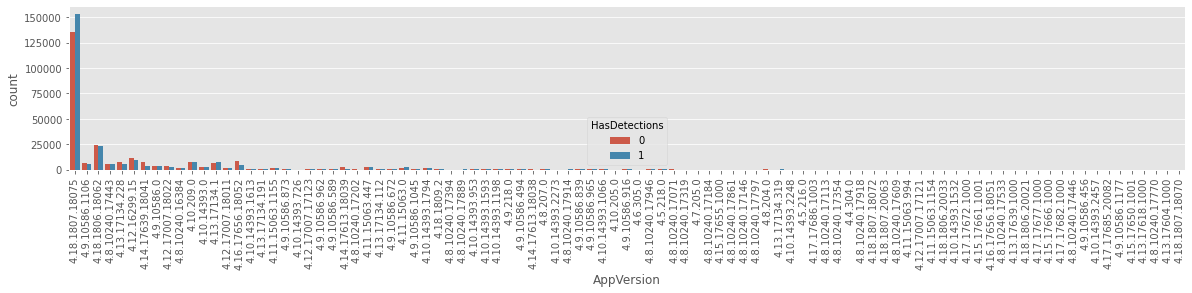

In [ ]:
# A simple vista pareciera que a más actualizada la versión más probabilidad de infección, pero también hay que tener en cuenta que son los mayores registros
plt.figure(figsize=[20,3])
plt.xticks(rotation=90)
sns.countplot(data=df, x='AppVersion', hue=TARGET)

In [ ]:
df['AppVersion'] = df['AppVersion'].str.replace(".", "").astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


#####**AvSigVersion**

###### AvSigVersion tiene 6455 valores distintos, vemos que no hay nulos. También podemos identificar que hay muchos minoritarios, pero aquí como se trata de una variable de versiones, podemos entender que hay un orden intrínseco, por lo que la convertiremos a numérica solamente

In [ ]:
df['AvSigVersion'].describe()

count           500000
unique            6455
top       1.273.1420.0
freq              5771
Name: AvSigVersion, dtype: object

In [ ]:
df['AvSigVersion'].value_counts()

1.273.1420.0    5771
1.263.48.0      5537
1.275.1140.0    5317
1.275.727.0     5214
1.273.371.0     4799
                ... 
1.235.450.0        1
1.225.3320.0       1
1.233.294.0        1
1.229.892.0        1
1.235.1538.0       1
Name: AvSigVersion, Length: 6455, dtype: int64

In [ ]:
df['AvSigVersion'] = df['AvSigVersion'].str.replace(".", "").astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


#####**IsBeta**

###### IsBeta tiene 2 valores distintos, pero uno de ellas tiene solo 1 registro, como creemos que no aporta valor alguno, vamos a proceder a eliminarla

In [ ]:
df['IsBeta'].describe()

count    500000.000000
mean          0.000002
std           0.001414
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: IsBeta, dtype: float64

In [ ]:
df['IsBeta'].value_counts()

0    499999
1         1
Name: IsBeta, dtype: int64

In [ ]:
df.drop('IsBeta',axis=1, inplace=True)

#####**RtpStateBitfield**

###### En esta variable tenemos un gran % de NaN, y al tratarse de una variable numerica lo que vamos a hacer es rellenar los nulos con un valor extremo (-1)


In [ ]:
df['RtpStateBitfield'].describe()

count    498168.000000
mean          6.846207
std           1.023049
min           0.000000
25%           7.000000
50%           7.000000
75%           7.000000
max          35.000000
Name: RtpStateBitfield, dtype: float64

In [ ]:
df['RtpStateBitfield'].value_counts(dropna = False)

7.0     484841
0.0      10610
NaN       1832
8.0       1277
5.0       1158
3.0        176
1.0        105
35.0         1
Name: RtpStateBitfield, dtype: int64

In [ ]:
df['RtpStateBitfield'].fillna(value=-1, inplace=True)

In [ ]:
df['RtpStateBitfield'].value_counts(dropna = False)

 7.0     484841
 0.0      10610
-1.0       1832
 8.0       1277
 5.0       1158
 3.0        176
 1.0        105
 35.0         1
Name: RtpStateBitfield, dtype: int64

#####**IsSxsPassiveMode**

###### Esta variable pareciera tener una relación alta con nuestro TARGET, aquellos equipos que se encuentran en PassiveMode activado (=1) tienen un % de media de más alto de infecciones

In [ ]:
df['IsSxsPassiveMode'].describe()

count    500000.000000
mean          0.017242
std           0.130172
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: IsSxsPassiveMode, dtype: float64

In [ ]:
df['IsSxsPassiveMode'].value_counts(dropna = False)

0    491379
1      8621
Name: IsSxsPassiveMode, dtype: int64

In [ ]:
pivotTable_func('IsSxsPassiveMode', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
IsSxsPassiveMode,,,
0,491379,246751,0.502160
1,8621,3202,0.371419


Text(0.5, 1.0, 'Microsoft Malware Prediction')

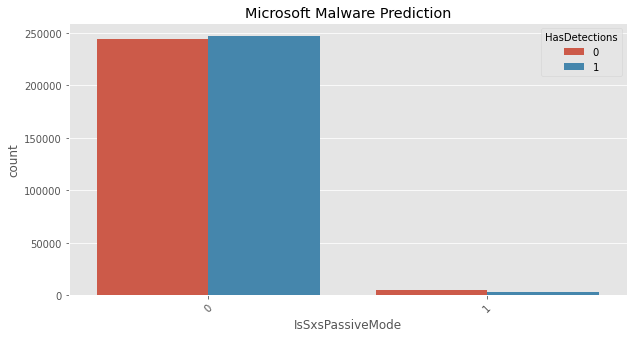

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x= 'IsSxsPassiveMode', hue = TARGET)
plt.xticks(rotation=45)
plt.title('Microsoft Malware Prediction')

#####**DefaultBrowsersIdentifier**

###### Esta variable tiene muchos valores NULOS (95%), vamos a proceder a eliminarla

In [ ]:
df['DefaultBrowsersIdentifier'].describe()

count    24061.000000
mean      1652.824529
std       1004.754276
min          1.000000
25%        788.000000
50%       1632.000000
75%       2381.000000
max       3209.000000
Name: DefaultBrowsersIdentifier, dtype: float64

In [ ]:
(df['DefaultBrowsersIdentifier'].value_counts(dropna = False) / df['DefaultBrowsersIdentifier'].size)*100

NaN       95.1878
239.0      0.5178
3195.0     0.4846
1632.0     0.3202
3176.0     0.2626
           ...   
1692.0     0.0002
2722.0     0.0002
914.0      0.0002
1648.0     0.0002
1427.0     0.0002
Name: DefaultBrowsersIdentifier, Length: 555, dtype: float64

In [ ]:
df.drop('DefaultBrowsersIdentifier',axis=1, inplace=True)

#####**AVProductStatesIdentifier**

###### Esta variable tiene muchas etiquetas (+ 5000) no podemos hacer un OHE, y al no tener orden intrínseco, tenemos que optar por otra opcion. Como tenemos varias etiquetas con pocos registros, llamo a mi funcion de get_num_values para identificar con cuantas etiquetas me quedo.

In [ ]:
df['AVProductStatesIdentifier'].describe()

count    498062.000000
mean      47850.908413
std       14023.085346
min           3.000000
25%       49480.000000
50%       53447.000000
75%       53447.000000
max       70492.000000
Name: AVProductStatesIdentifier, dtype: float64

In [ ]:
# Reviso la cantidad de etiquetas a mantener
get_num_values(df,'AVProductStatesIdentifier')

8

In [ ]:
df['AVProductStatesIdentifier'] = set_Others_num(df,'AVProductStatesIdentifier',8)

In [ ]:
pivotTable_func('AVProductStatesIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
AVProductStatesIdentifier,,,
53447.0,326463,181517,0.556011
46413.0,6343,3109,0.490147
47238.0,18436,8525,0.462411
23657.0,5717,2382,0.416652
49480.0,5684,2298,0.404293
-1.0,90312,35451,0.392539
62773.0,14931,5672,0.379881
7945.0,26642,9356,0.351175


In [ ]:
df['AVProductStatesIdentifier'].value_counts(normalize = True,dropna = False)

53447.0    0.652926
-1.0       0.180624
7945.0     0.053284
47238.0    0.036872
62773.0    0.029862
46413.0    0.012686
23657.0    0.011434
49480.0    0.011368
41571.0    0.010944
Name: AVProductStatesIdentifier, dtype: float64

In [ ]:
len(df['AVProductStatesIdentifier'].unique())

9

#####**AVProductsInstalled**

###### Esta variable tiene pocas etiquetas, los NaN se refieren a aquellos ordenadores sin productos instalados, por lo que vamos a rellenar los nulos con valor extremo.
###### Vemos que esta variable juega un rol importante.
###### Vamos a dejarla como esta y asignarle un orden



In [ ]:
df['AVProductsInstalled'].describe()

count    498062.000000
mean          1.326763
std           0.523000
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: AVProductsInstalled, dtype: float64

In [ ]:
df['AVProductsInstalled'].value_counts(dropna = False)

1.0    348046
2.0    137856
3.0     11617
NaN      1938
4.0       514
5.0        29
Name: AVProductsInstalled, dtype: int64

In [ ]:
# reemplazamos los nulos por la mediana

df["AVProductsInstalled"].fillna(0, inplace=True)

In [ ]:
pivotTable_func('AVProductsInstalled', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
AVProductsInstalled,,,
1.0,348046,190800,0.548203
2.0,137856,54902,0.398256
0.0,1938,741,0.382353
3.0,11617,3378,0.290781
4.0,514,128,0.249027
5.0,29,4,0.137931


#####**AVProductsEnabled**

###### Esta variable parece tener relación directa con la anterior. La misma tiene pocas etiquetas, por lo que podemos hacer un OHE, pero primero debemos rellenar los NULOS en este caso con 0, porque considero que los NaN hace referncia a aquellos Products sin habilitar.

In [ ]:
df['AVProductsEnabled'].describe()

count    498062.000000
mean          1.020714
std           0.166608
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: AVProductsEnabled, dtype: float64

In [ ]:
df['AVProductsEnabled'].value_counts(dropna = False)

1.0    485179
2.0     11074
NaN      1938
0.0      1467
3.0       316
4.0        26
Name: AVProductsEnabled, dtype: int64

In [ ]:
pivotTable_func('AVProductsEnabled', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
AVProductsEnabled,,,
1.0,485179,244821,0.504599
0.0,1467,544,0.370825
3.0,316,111,0.351266
2.0,11074,3732,0.337006
4.0,26,4,0.153846


In [ ]:
df["AVProductsEnabled"].fillna(0, inplace=True)

In [ ]:
pivotTable_func('AVProductsEnabled', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
AVProductsEnabled,,,
1.0,485179,244821,0.504599
0.0,3405,1285,0.377386
3.0,316,111,0.351266
2.0,11074,3732,0.337006
4.0,26,4,0.153846


#####**HasTpm**

###### Esta variable es una booleana y tiene una distribución repartida.

In [ ]:
df['HasTpm'].value_counts()

1    493908
0      6092
Name: HasTpm, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


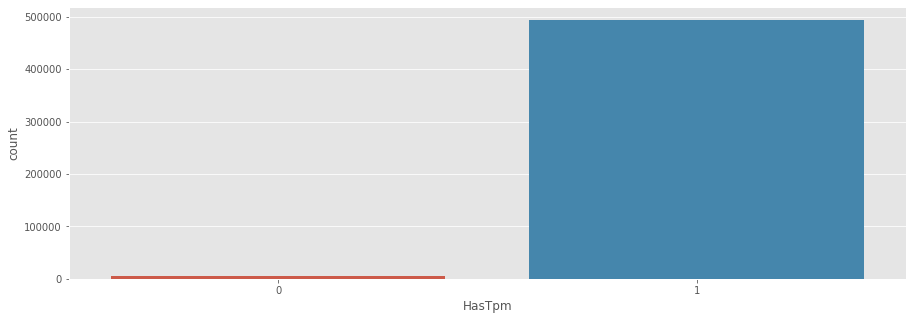

In [ ]:
plt.figure(figsize = (15,5))
sns.countplot(df['HasTpm'])

In [ ]:
pivotTable_func('HasTpm', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
HasTpm,,,
1,493908,247105,0.500306
0,6092,2848,0.467498


#####**CountryIdentifier**

###### Esta variable tiene muchos valores únicos (200) por lo que el OHE queda descartado. Al ser numeros, no tengo posibilidad de saber de que paises se tratan, aunque tal vez recurriendo a fuente externa lo obtengamos. Vamos a dejarlo con un Frequency Encoding

In [ ]:
df['CountryIdentifier'].describe()

count    500000.000000
mean        108.037454
std          63.068540
min           1.000000
25%          51.000000
50%          97.000000
75%         162.000000
max         222.000000
Name: CountryIdentifier, dtype: float64

In [ ]:
len(df['CountryIdentifier'].unique())

222

#####**CityIdentifier**


###### Esta variable tiene muchos valores únicos (37K) por lo que el OHE también queda descartado. A su vez contiene nulos, por lo que propongo rellenar el CityIdentifier con la moda de la ciudad correspondiente a su CountryIdentifier. Luego haremos un Frequency Enconding




In [ ]:
# Creo una lista con todos los paises unicos, para luego asignar el valor de la ciudad que mas se repetite
country_list = list(df['CountryIdentifier'][df['CityIdentifier'].notnull()].unique())

In [ ]:
# Hacemos un for loop para extrae la city que mas se repite a nivel de country
max_cities_per_country = []

for i in country_list:
  most_freq_city = df[(df['CityIdentifier'].notnull()) & (df['CountryIdentifier'] == i)]['CityIdentifier'].max()
  max_cities_per_country.append(most_freq_city)
print(max_cities_per_country)


[141853.0, 154146.0, 166969.0, 166746.0, 166541.0, 166873.0, 167682.0, 165541.0, 157490.0, 165266.0, 166499.0, 65822.0, 165808.0, 133198.0, 164840.0, 164815.0, 166975.0, 166544.0, 151612.0, 165694.0, 166973.0, 166978.0, 146917.0, 157940.0, 167958.0, 166387.0, 164409.0, 166810.0, 142323.0, 142405.0, 166914.0, 151271.0, 165419.0, 128749.0, 151352.0, 165044.0, 166515.0, 165477.0, 164865.0, 167515.0, 167732.0, 167900.0, 166554.0, 167954.0, 166756.0, 159579.0, 167659.0, 165025.0, 167463.0, 167907.0, 164438.0, 167316.0, 166663.0, 165199.0, 150155.0, 167625.0, 167658.0, 38044.0, 167835.0, 166832.0, 151162.0, 484.0, 152148.0, 167318.0, 157699.0, 166763.0, 131208.0, 166984.0, 165018.0, 143779.0, 122333.0, 166293.0, 165709.0, 166872.0, 165935.0, 128063.0, 39990.0, 155751.0, 155247.0, 167650.0, 152358.0, 152497.0, 166905.0, 165128.0, 165648.0, 161606.0, 164977.0, 155675.0, 146343.0, 108095.0, 137781.0, 154883.0, 101124.0, 163215.0, 152593.0, 158236.0, 163843.0, 132449.0, 165805.0, 149405.0, 15046

In [ ]:
# A modo de ejemplo identifico para el pais 8 cual es su ciudad que mas se repite

df[(df['CityIdentifier'].notnull()) & (df['CountryIdentifier'] == 8)]['CityIdentifier'].max()

141853.0

In [ ]:
# Creo una lista con todos los paises unicos, para luego asignar el valor de la ciudad que mas se repetite

country_list = list(df['CountryIdentifier'][df['CityIdentifier'].notnull()].unique())

In [ ]:
# creo los DF para luego concatenar ambas listas

df_max_cities_per_country = pd.DataFrame(max_cities_per_country)

In [ ]:
df_country = pd.DataFrame(country_list)

In [ ]:
# Antes de concatenar chequeo el shape de ambos df

df_max_cities_per_country.shape

(222, 1)

In [ ]:
df_country.shape

(222, 1)

In [ ]:
# Concatenamos ambos df

df_most_freq_city_by_coutry = pd.concat([df_country, df_max_cities_per_country], axis=1)

In [ ]:
# Renombro las columnas del DF

df_most_freq_city_by_coutry.set_axis(['CountryIdentifier', 'CityIdentifierMax'], axis=1,inplace=True)

In [ ]:
# Tengo 18K sin ciudad, vamos a rellenarlos con los valores maximos de la ciudad, dependiendo el pais que tenga cada linea
df[df['CityIdentifier'].isnull()]

,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
970f512d299560023cd7a52bcc9be960,win8defender,11151001,418180618062,12735090,7.0,0,7945.0,2.0,1.0,1,70,NaN,NaN,277.0,75,windows10,x86,10.0.0.0,16299,256,rs3,16299.15.x86fre.rs3_release.170928-1534,Pro,1.0,0,NaN,0.0,117.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,35160.0,4.0,5.0,2525.0,NaN,476940.0,HDD,110043.0,0,4096.0,Notebook,15.5,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.16299.547,x86,rs3_release,16299,547,Professional,PROFESSIONAL,Upgrade,8.0,31,Off,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,16989.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
876ad82333e04faf34cb8fd21e2b4f0f,win8defender,11152001,418180718075,127513120,7.0,0,47238.0,2.0,1.0,1,142,NaN,18.0,157.0,68,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,0.0,108.0,NaN,1.0,1.0,Detachable,Windows.Desktop,2668.0,171468.0,4.0,5.0,1916.0,NaN,59640.0,SSD,58362.0,0,4096.0,Detachable,10.1,1280.0,800.0,Slate,NaN,0.000000e+00,10.0.15063.1155,amd64,rs2_release,15063,1155,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,8.0,31,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,628.0,12995.0,1,NaN,0.0,1,1,1.0,0.0,1.0,0
1c6449d14b374a014568de15f8437f6e,win8defender,11152001,41317134228,127510900,7.0,0,7945.0,2.0,1.0,1,44,NaN,27.0,143.0,226,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,170874.0,4.0,5.0,2373.0,NaN,953869.0,HDD,118695.0,0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.17134.228,amd64,rs4_release,17134,228,CoreSingleLanguage,CORE_SINGLELANGUAGE,UUPUpgrade,9.0,34,FullAuto,0,INVALID_LICENSE,OEM:DM,NaN,0.0,Retail,NaN,628.0,23576.0,0,NaN,0.0,0,0,0.0,1.0,10.0,0
5104cbf0824efaf08881ee026ce979ff,win8defender,11151001,410143930,12734220,7.0,0,62773.0,1.0,1.0,1,131,NaN,NaN,277.0,75,windows10,x64,10.0.0.0,14393,256,rs1,14393.0.amd64fre.rs1_release.160715-1616,Pro,0.0,0,NaN,0.0,94.0,ExistsNotSet,1.0,1.0,Notebook,Windows.Desktop,585.0,189533.0,2.0,5.0,2097.0,NaN,476940.0,HDD,99433.0,0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.14393.0,amd64,rs1_release,14393,0,Professional,PROFESSIONAL,IBSClean,8.0,31

In [ ]:
# Tengo DF por PAIS / Ciudad mas se repite
df_most_freq_city_by_coutry

,CountryIdentifier,CityIdentifierMax
0,8,141853.0
1,129,154146.0
2,149,166969.0
3,164,166746.0
4,207,166541.0
...,...,...
217,10,143639.0
218,216,90153.0
219,128,87390.0
220,193,127690.0


In [ ]:
# Vamos a mergear los dos DF para tener el dato de la ciudad que mas se repite

df = df.merge(df_most_freq_city_by_coutry, on='CountryIdentifier', how='left')

In [ ]:
df.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,...,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,CityIdentifierMax
0,win8defender,11151001,418180718075,127312340,7.0,0,53447.0,1.0,1.0,1,8,85219.0,NaN,205.0,172,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,1443.0,275891.0,4.0,5.0,2273.0,NaN,953869.0,...,952838.0,0,8192.0,AllinOne,23.0,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,27.0,120,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,19951.0,0,NaN,0.0,0,0,0.0,0.0,11.0,1,141853.0
1,win8defender,11151001,418180718075,127312820,7.0,0,53447.0,1.0,1.0,1,129,54198.0,NaN,126.0,124,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2102.0,248850.0,4.0,5.0,2660.0,NaN,476940.0,...,457600.0,0,8192.0,Notebook,13.2,1280.0,720.0,Mobile,lion,0.000000e+00,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,18.0,72,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,486.0,48753.0,0,0.0,0.0,0,0,0.0,1.0,3.0,0,154146.0
2,win8defender,11151001,49105861106,12737810,7.0,0,-1.0,2.0,1.0,1,149,122689.0,27.0,181.0,56,windows10,x64,10.0.0.0,10586,768,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Home,1.0,0,NaN,0.0,74.0,RequireAdmin,1.0,1.0,Convertible,Windows.Desktop,2206.0,238234.0,4.0,5.0,2998.0,NaN,244198.0,...,221251.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,lion,0.000000e+00,10.0.10586.1176,amd64,th2_release_sec,10586,1176,Core,CORE,Update,24.0,109,Notify,0,IS_GENUINE,Retail,NaN,0.0,Retail,0.0,554.0,33111.0,1,0.0,0.0,1,1,0.0,0.0,15.0,0,166969.0
3,win8defender,11152001,418180718075,127516390,7.0,0,53447.0,1.0,1.0,1,164,114587.0,27.0,205.0,172,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,525.0,265410.0,8.0,5.0,2880.0,NaN,228936.0,...,228321.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,5.770000e+02,10.0.17134.286,amd64,rs4_release,17134,286,Core,CORE,IBSClean,27.0,120,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,48473.0,1,NaN,0.0,0,0,0.0,0.0,15.0,1,166746.0
4,win8defender,11152001,418180718075,12755110,7.0,0,47238.0,2.0,1.0,1,207,724

In [ ]:
# Voy a usar el de CityIdentifierMax para rellenar los NaN en CityIdentifier

df['CityIdentifier'].fillna(df['CityIdentifierMax'], inplace=True)

In [ ]:
# Chequeo que no haya NaN aquí

df['CityIdentifier'].isnull().sum()

0

In [ ]:
# Elimino la columna auxiliar de CityIdentifierMax 

df.drop('CityIdentifierMax',axis=1, inplace=True)

In [ ]:
pivotTable_func('CityIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
CityIdentifier,,,
7.0,1,1,1.0
53685.0,4,4,1.0
53581.0,1,1,1.0
128376.0,1,1,1.0
128373.0,1,1,1.0
...,...,...,...
58011.0,1,0,0.0
124311.0,1,0,0.0


#####**OrganizationIdentifier**

###### Esta variable tiene 45 valores únicos por lo que podríamos realizar un OHE. Primero rellenaremos los nulos con un valor extremo, y luego a pesar de ser 45 etiquetas, hay muchos valores minoritarios, vamos a agruparlos antes de hacer el OHE.

In [ ]:
df['OrganizationIdentifier'].describe()

count    345437.000000
mean         24.869936
std           5.613712
min           1.000000
25%          18.000000
50%          27.000000
75%          27.000000
max          52.000000
Name: OrganizationIdentifier, dtype: float64

In [ ]:
len(df['OrganizationIdentifier'].unique())

45

In [ ]:
df['OrganizationIdentifier'].value_counts(dropna = False)

27.0    234885
NaN     154563
18.0     98842
48.0      3658
50.0      2538
37.0      1048
11.0      1037
49.0       747
46.0       641
14.0       255
32.0       230
36.0       207
52.0       174
33.0       171
2.0        153
5.0        110
40.0       100
28.0        98
4.0         79
10.0        69
51.0        53
1.0         39
20.0        38
8.0         37
6.0         25
31.0        23
47.0        22
39.0        21
22.0        21
3.0         20
21.0        19
16.0        16
19.0        10
29.0         8
42.0         8
7.0          7
44.0         6
26.0         6
43.0         4
45.0         4
41.0         2
35.0         2
23.0         2
25.0         1
17.0         1
Name: OrganizationIdentifier, dtype: int64

In [ ]:
get_num_values(df, 'OrganizationIdentifier')

3

In [ ]:
df['OrganizationIdentifier'] = set_Others_num(df, 'OrganizationIdentifier', 3)

In [ ]:
df['OrganizationIdentifier'].value_counts()

27.0    234885
-1.0    162615
18.0     98842
48.0      3658
Name: OrganizationIdentifier, dtype: int64

#####***GeoNameIdentifier***

###### Esta variable tiene muchos valores únicos por lo que no podríamos realizar un OHE. Primero rellenaremos los nulos con valor extremo, y luego a pesar de ser 200 aprox etiquetas, hay muchos valores minoritarios, vamos a agruparlos antes de hacer un Frequency Enconding.

In [ ]:
df['GeoNameIdentifier'].describe()

count    499984.000000
mean        169.730423
std          89.325172
min           1.000000
25%          89.000000
50%         181.000000
75%         267.000000
max         296.000000
Name: GeoNameIdentifier, dtype: float64

In [ ]:
len(df['GeoNameIdentifier'].unique())

269

In [ ]:
df['GeoNameIdentifier'].value_counts()

277.0    86080
211.0    23593
53.0     22977
89.0     20174
240.0    19489
         ...  
280.0        1
231.0        1
113.0        1
221.0        1
132.0        1
Name: GeoNameIdentifier, Length: 268, dtype: int64

In [ ]:
get_num_values(df, 'GeoNameIdentifier')

27

In [ ]:
df['GeoNameIdentifier'] = set_Others_num(df, 'GeoNameIdentifier', 27)

In [ ]:
df['GeoNameIdentifier'].value_counts()

-1.0     123382
277.0     86080
211.0     23593
53.0      22977
89.0      20174
240.0     19489
35.0      19144
167.0     18845
276.0     16600
267.0     12106
126.0     11028
119.0     10419
98.0      10234
138.0      9717
255.0      9008
57.0       8722
10.0       8008
204.0      7776
52.0       7764
181.0      7297
120.0      7104
45.0       6388
205.0      6315
202.0      6162
224.0      5818
157.0      5607
201.0      5191
117.0      5052
Name: GeoNameIdentifier, dtype: int64

#####***LocaleEnglishNameIdentifier***

###### Esta variable tiene muchos valores únicos por lo que no podríamos realizar un OHE. A pesar de ser 200 aprox etiquetas, hay muchos valores minoritarios, vamos a agruparlos antes de hacer un OHE.

In [ ]:
df['LocaleEnglishNameIdentifier'].value_counts()

75     117818
182     25187
42      23007
74      22894
88      20988
        ...  
152         1
155         1
165         1
190         1
127         1
Name: LocaleEnglishNameIdentifier, Length: 233, dtype: int64

In [ ]:
len(df['LocaleEnglishNameIdentifier'].unique())

233

In [ ]:
get_num_values(df, 'LocaleEnglishNameIdentifier')

24

In [ ]:
df['LocaleEnglishNameIdentifier'] = set_Others_num(df, 'LocaleEnglishNameIdentifier', 24)

In [ ]:
df['LocaleEnglishNameIdentifier'].value_counts()

75     117818
-1     106353
182     25187
42      23007
74      22894
88      20988
233     19225
171     19027
227     18427
251     11889
124     10843
103     10035
134      9700
64       9526
46       8994
218      8676
214      7782
217      7686
170      7680
56       6809
172      6270
70       5873
68       5157
231      5110
60       5044
Name: LocaleEnglishNameIdentifier, dtype: int64

#####***Platform***


###### Con esta variable podemos hacer un OHE tranquilamente, y vemos que la distribución del target se encuentra bien repartida es esta etiqueta, 





In [ ]:
df['Platform'].value_counts(dropna=False)

windows10      483048
windows8        10825
windows7         5314
windows2016       813
Name: Platform, dtype: int64

In [ ]:
pivotTable_func('Platform', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Platform,,,
windows8,10825,5614,0.518614
windows10,483048,241476,0.499901
windows7,5314,2562,0.482123
windows2016,813,301,0.370234


#####**Processor**

###### Con esta variable también podemos hacer un OHE tranquilamente, aunque tenemos una etiqueta con pocos valores, al tratarse de un Decision Tree dejaremos que él decida el tratamiento de la misma.

In [ ]:
df['Processor'].value_counts(dropna=False)

x64      454423
x86       45563
arm64        14
Name: Processor, dtype: int64

In [ ]:
# Esta variable sera importante al momento de predecir, vemos la influencia del processor x86, pareciera ser que a mejor procesador, menor el impacto de infeccion.
pivotTable_func('Processor', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Processor,,,
x64,454423,232321,0.511244
x86,45563,17632,0.386981
arm64,14,0,0.000000


#####**OsVer**

###### Con esta variable al tener un orden intriseco la dejaremos tal y como esta.

In [ ]:
df['OsVer'].value_counts(dropna=False)

10.0.0.0      483830
6.3.0.0        10818
6.1.1.0         5281
6.1.0.0           33
10.0.3.0          12
10.0.1.0           7
6.3.3.0            2
10.0.0.1           2
6.3.1.0            2
10.0.32.72         2
10.0.32.0          1
10.0.80.0          1
10.0.5.0           1
10.0.2.0           1
6.3.5.0            1
10.0.4.0           1
10.0.8.0           1
10.0.0.112         1
6.3.32.72          1
6.3.7.0            1
10.0.7.0           1
Name: OsVer, dtype: int64

In [ ]:
df['OsVer'] = df['OsVer'].str.replace(".", "").astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
pivotTable_func('OsVer', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
OsVer,,,
10020,1,1,1.000000
10070,1,1,1.000000
1000112,1,1,1.000000
100320,1,1,1.000000
6370,1,1,1.000000
10001,2,2,1.000000
10080,1,1,1.000000
10050,1,1,1.000000


#####**OsBuild**

###### Con esta variable también podemos hacer un OHE tranquilamente, hay muchos valores minoritarios, vamos a agruparlos antes de hacer el OHE.

In [ ]:
df['OsBuild'].value_counts(dropna=False)

17134    220779
16299    139901
15063     43352
14393     40717
10586     22955
10240     15014
9600      10825
7601       5281
17692       155
17738       134
17744       129
17758        86
17746        62
17713        60
17754        56
17751        53
17741        51
17755        45
17735        37
17686        36
17733        34
17763        33
7600         33
17760        31
17682        20
17677        17
18234        16
17672        15
18242        12
18237        12
17661         9
17666         8
17723         4
17634         4
17639         3
17730         3
17618         3
17747         3
17655         2
17650         2
17753         1
17604         1
18214         1
17711         1
17704         1
18219         1
17623         1
17749         1
Name: OsBuild, dtype: int64

In [ ]:
get_num_values(df, 'OsBuild')

8

In [ ]:
df['OsBuild'] = set_Others_num(df, 'OsBuild', 8)

In [ ]:
pivotTable_func('OsBuild', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
OsBuild,,,
17134,220779,114996,0.520865
9600,10825,5614,0.518614
16299,139901,68735,0.491312
10240,15014,7309,0.486812
7601,5281,2552,0.483242
15063,43352,20778,0.479286
14393,40717,18848,0.462902
10586,22955,10608,0.462122


#####**OsSuite**

###### Con esta variable también podemos hacer un OHE.

In [ ]:
df['OsSuite'].value_counts(dropna=False)

768    311226
256    187951
272       677
16         53
400        47
305        33
784        10
274         2
18          1
Name: OsSuite, dtype: int64

#####**OsPlatformSubRelease**

###### Con esta variable también podemos hacer un OHE.

In [ ]:
df['OsPlatformSubRelease'].value_counts(dropna=False)

rs4           220779
rs3           139901
rs2            43352
rs1            40717
th2            22955
th1            15014
windows8.1     10825
windows7        5314
prers5          1143
Name: OsPlatformSubRelease, dtype: int64

In [ ]:
# Esta variable parece importante ya que tenemos los registros muy repartidos con valores de media distintos
pivotTable_func('OsPlatformSubRelease', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
OsPlatformSubRelease,,,
rs4,220779,114996,0.520865
windows8.1,10825,5614,0.518614
rs3,139901,68735,0.491312
th1,15014,7309,0.486812
windows7,5314,2562,0.482123
rs2,43352,20778,0.479286
rs1,40717,18848,0.462902
th2,22955,10608,0.462122


#####**OsBuildLab**

###### Esta variable tiene muchos valores únicos por lo que no podríamos realizar un OHE. Primero rellenaremos el único nulo con la moda, y luego a pesar de ser 400 aprox etiquetas, hay muchos valores minoritarios, vamos a agruparlos antes de hacer un Frequency Enconding.

In [ ]:
df['OsBuildLab'].describe()

count                                       499999
unique                                         453
top       17134.1.amd64fre.rs4_release.180410-1804
freq                                        206436
Name: OsBuildLab, dtype: object

In [ ]:
df['OsBuildLab'].value_counts(dropna=False)

17134.1.amd64fre.rs4_release.180410-1804                 206436
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908     69884
16299.15.amd64fre.rs3_release.170928-1534                 53826
15063.0.amd64fre.rs2_release.170317-1834                  39908
17134.1.x86fre.rs4_release.180410-1804                    14334
                                                          ...  
7600.21980.amd64fre.win7_ldr.150318-1623                      1
9600.18146.x86fre.winblue_ltsb.151121-0600                    1
17692.1000.x86fre.rs_prerelease.180609-1317                   1
14393.2156.amd64fre.rs1_release_inmarket.180321-1733          1
9600.18007.amd64fre.winblue_ltsb.150807-0612                  1
Name: OsBuildLab, Length: 454, dtype: int64

In [ ]:
get_num_values(df, 'OsBuildLab')

9

In [ ]:
df['OsBuildLab'] =  set_Others(df, 'OsBuildLab', 9)

In [ ]:
# Esta variable parece importante ya que tenemos los registros muy repartidos con valores de media distintos

pivotTable_func('OsBuildLab', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
OsBuildLab,,,
17134.1.amd64fre.rs4_release.180410-1804,206436,109335,0.529631
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908,69884,36047,0.515812
14393.2189.amd64fre.rs1_release.180329-1711,10724,5393,0.502891
10240.17443.amd64fre.th1.170602-2340,9538,4758,0.498847
16299.15.amd64fre.rs3_release.170928-1534,53826,26378,0.490061
15063.0.amd64fre.rs2_release.170317-1834,39908,19454,0.487471
Others,73860,34339,0.464920
10586.1176.amd64fre.th2_release_sec.170913-1848,8385,3778,0.450566


#####**SkuEdition**

###### Esta variable tiene pocos valores únicos y sin nulos por lo que podemos realizar un OHE.

In [ ]:
df['SkuEdition'].value_counts(dropna=False)

Home               308567
Pro                181042
Invalid              4423
Education            2321
Enterprise           1999
Enterprise LTSB      1141
Cloud                 309
Server                198
Name: SkuEdition, dtype: int64

In [ ]:
pivotTable_func('SkuEdition', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
SkuEdition,,,
Enterprise LTSB,1141,614,0.538124
Education,2321,1202,0.517880
Enterprise,1999,1035,0.517759
Pro,181042,92853,0.512881
Home,308567,152007,0.492622
Invalid,4423,2069,0.467782
Cloud,309,121,0.391586
Server,198,52,0.262626


#####**IsProtected**

###### Esta variable pareciera ser una booleana, pero posee nulos, vamos a asumir que los NaN se tratan de que no es un equipo protegido. Por lo que vamos a rellenar los nulls con 0 

In [ ]:
df['IsProtected'].value_counts(dropna=False)

1.0    471073
0.0     27001
NaN      1926
Name: IsProtected, dtype: int64

In [ ]:
df['IsProtected'].fillna(value=0, inplace=True)

In [ ]:
pivotTable_func('IsProtected', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
IsProtected,,,
1.0,471073,238877,0.507091
0.0,28927,11076,0.382895


#####**AutoSampleOptIn**

###### Esta variable es una booleana, pero añade poco valor, procedemos a eliminarla.

In [ ]:
df['AutoSampleOptIn'].value_counts(dropna=False)

0    499986
1        14
Name: AutoSampleOptIn, dtype: int64

In [ ]:
pivotTable_func('AutoSampleOptIn', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
AutoSampleOptIn,,,
1,14,7,0.500000
0,499986,249946,0.499906


In [ ]:
df.drop('AutoSampleOptIn',axis=1, inplace=True)

#####**PuaMode**

###### Esta variable es una booleana, pero añade poco valor, procedemos a eliminarla.

In [ ]:
df['PuaMode'].value_counts(dropna=False)

NaN    499874
on        126
Name: PuaMode, dtype: int64

In [ ]:
pivotTable_func('PuaMode', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
PuaMode,,,
on,126,95,0.753968


In [ ]:
df.drop('PuaMode',axis=1, inplace=True)

#####**SMode**

###### Esta variable pareciera es una booleana, parecido al caso de isProtected, podriamos asumir que los NaN son off, por ende 0. En ese caso, rellenaríamos nulos con 0, y quedaría la variable booleana, pero de todas formas quedarían pocas observaciones en 1, para mantener criterios, eliminamos variable

In [ ]:
df['SMode'].value_counts(dropna=False)

0.0    469946
NaN     29848
1.0       206
Name: SMode, dtype: int64

In [ ]:
df.drop('SMode',axis=1, inplace=True)

#####**IeVerIdentifier**

###### Esta variable pareciera tiene muchas etiqietas como para hacer un OHE, vmaos a rellenar nulos con valor extremo, y luego hacer un OHE

In [ ]:
df['IeVerIdentifier'].describe()

count    496791.000000
mean        126.662566
std          42.634892
min           8.000000
25%         111.000000
50%         135.000000
75%         137.000000
max         429.000000
Name: IeVerIdentifier, dtype: float64

In [ ]:
df['IeVerIdentifier'].value_counts(dropna=False)

137.0    219142
117.0     98667
108.0     26353
111.0     26143
98.0      19731
          ...  
79.0          1
15.0          1
54.0          1
192.0         1
281.0         1
Name: IeVerIdentifier, Length: 180, dtype: int64

In [ ]:
get_num_values(df, 'IeVerIdentifier')

13

In [ ]:
df['IeVerIdentifier'] = set_Others_num(df, 'IeVerIdentifier', 13)

In [ ]:
pivotTable_func('IeVerIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
IeVerIdentifier,,,
333.0,8751,4714,0.538681
137.0,219142,114170,0.520986
105.0,9695,4938,0.509335
111.0,26143,13211,0.505336
117.0,98667,48613,0.492698
53.0,11352,5503,0.484760
108.0,26353,12540,0.475847
98.0,19731,9323,0.472505


In [ ]:
len(df['IeVerIdentifier'].unique())

14

#####**SmartScreen**

###### Esta variable es categorica y solo tiene 12 etiquetas únicas, por lo que vamos a rellenar nulos con la moda, y luego hacer un OHE. Pero aqui los nulos son una parte importante del dataset.

In [ ]:
df['SmartScreen'].describe()

count           321404
unique              12
top       RequireAdmin
freq            241594
Name: SmartScreen, dtype: object

In [ ]:
df['SmartScreen'].value_counts(dropna=False)

RequireAdmin    241594
NaN             178596
ExistsNotSet     58497
Off              10388
Warn              7530
Prompt            1950
Block             1274
off                 75
On                  53
&#x02;              20
&#x01;              14
on                   8
requireadmin         1
Name: SmartScreen, dtype: int64

In [ ]:
#Agrupamos etiquetas parecidas

df['SmartScreen'].replace('off', 'Off', inplace=True)

In [ ]:
#Agrupamos etiquetas parecidas

df['SmartScreen'].replace('on', 'On', inplace=True)

In [ ]:
#Agrupamos etiquetas parecidas

df['SmartScreen'].replace('requireadmin', 'RequireAdmin', inplace=True)

In [ ]:
df['SmartScreen'].fillna(value='Others', inplace=True)

In [ ]:
pivotTable_func('SmartScreen', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
SmartScreen,,,
ExistsNotSet,58497,47115,0.805426
On,61,40,0.655738
Warn,7530,4306,0.571846
&#x02;,20,11,0.550000
Block,1274,640,0.502355
Off,10463,5098,0.487241
Others,178596,85919,0.481080
Prompt,1950,928,0.475897


#####**Firewall**

###### Esta variable es booleana, debemos rellenar nulos primero con 0, asumiedo igual criterio que con la variable IsProtected. 

In [ ]:
df['Firewall'].value_counts(dropna=False)

1.0    484071
0.0     10767
NaN      5162
Name: Firewall, dtype: int64

In [ ]:
df['Firewall'].fillna(value=0, inplace=True)

In [ ]:
pivotTable_func('Firewall', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Firewall,,,
1.0,484071,242106,0.500146
0.0,15929,7847,0.492624


#####**UacLuaenable**

###### Pareciera ser booleana, pero hay otros valores que hacen dudar, vamos a rellenar NaN con 0, asumiendo mismo criterio que con isProtected, y luego hacemos un OHE

In [ ]:
df['UacLuaenable'].value_counts(dropna=False)

1.0          496276
0.0            3086
NaN             623
48.0             13
2.0               1
6357062.0         1
Name: UacLuaenable, dtype: int64

In [ ]:
df['UacLuaenable'].fillna(value=0, inplace=True)

In [ ]:
pivotTable_func('UacLuaenable', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
UacLuaenable,,,
2.0,1,1,1.000000
6357062.0,1,1,1.000000
48.0,13,10,0.769231
1.0,496276,248115,0.499954
0.0,3709,1826,0.492316


#####**Census_MDC2FormFactor**

###### Con esta variable categorica podriamos haceR un OHE

In [ ]:
df['Census_MDC2FormFactor'].value_counts(dropna=False)

Notebook        320948
Desktop         109527
Convertible      22369
Detachable       16802
AllInOne         16372
PCOther           7800
LargeTablet       3645
SmallTablet       1797
SmallServer        496
MediumServer       192
LargeServer         50
ServerOther          2
Name: Census_MDC2FormFactor, dtype: int64

In [ ]:
pivotTable_func('Census_MDC2FormFactor', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_MDC2FormFactor,,,
Desktop,109527,57306,0.523213
AllInOne,16372,8384,0.512094
Notebook,320948,161411,0.502919
Convertible,22369,11025,0.492870
PCOther,7800,3715,0.476282
SmallServer,496,191,0.385081
Detachable,16802,6351,0.377991
MediumServer,192,62,0.322917


#####**Census_DeviceFamily**

###### Con esta variable categorica podriamos agrupar primero, para no dejar una etiqueta unica, y luego hacemos un OHE, pero de todas formas una sola de ellas concentra la mayor parte de las observaciones, procedemos a eliminar variable

In [ ]:
df['Census_DeviceFamily'].value_counts(dropna=False)

Windows.Desktop    499183
Windows.Server        816
Windows                 1
Name: Census_DeviceFamily, dtype: int64

In [ ]:
pivotTable_func('Census_DeviceFamily', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_DeviceFamily,,,
Windows.Desktop,499183,249651,0.500119
Windows.Server,816,302,0.370098
Windows,1,0,0.000000


In [ ]:
df.drop('Census_DeviceFamily',axis=1, inplace=True)

#####**Census_OEMNameIdentifier**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un. OHE

In [ ]:
df['Census_OEMNameIdentifier'].describe()

count    494619.000000
mean       2218.646481
std        1315.709604
min          54.000000
25%        1443.000000
50%        2102.000000
75%        2668.000000
max        6143.000000
Name: Census_OEMNameIdentifier, dtype: float64

In [ ]:
get_num_values(df, 'Census_OEMNameIdentifier')

14

In [ ]:
df['Census_OEMNameIdentifier'] = set_Others_num(df, 'Census_OEMNameIdentifier', 14)

In [ ]:
pivotTable_func('Census_OEMNameIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_OEMNameIdentifier,,,
3035.0,7596,4361,0.574118
1980.0,16157,9066,0.561119
4589.0,17404,9670,0.555619
4909.0,7638,4052,0.530505
525.0,47299,24655,0.521258
2102.0,57924,29863,0.515555
1443.0,53210,27159,0.510412
2668.0,72011,35964,0.499424


#####**Census_OEMModelIdentifier**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un Frequency Encoding

In [ ]:
df['Census_OEMModelIdentifier'].describe()

count    494236.000000
mean     239128.046882
std       72048.883577
min           1.000000
25%      189641.750000
50%      247520.000000
75%      304438.000000
max      345493.000000
Name: Census_OEMModelIdentifier, dtype: float64

In [ ]:
get_num_values(df, 'Census_OEMModelIdentifier')

4

In [ ]:
df['Census_OEMModelIdentifier'] = set_Others_num(df, 'Census_OEMModelIdentifier', 4)

In [ ]:
pivotTable_func('Census_OEMModelIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_OEMModelIdentifier,,,
313586.0,17092,9515,0.556693
317708.0,6541,3529,0.539520
317701.0,7676,4078,0.531266
242491.0,14726,7661,0.520236
-1.0,453965,225170,0.496007


#####**Census_ProcessorCoreCount**

###### Con esta variable categorica podriamos entender que se trata de la cantidad de nucleos de los procesadores. Vamos a rellenar los NaN con val extremo.


In [ ]:
df['Census_ProcessorCoreCount'].value_counts(dropna=False)

4.0     304102
2.0     129178
8.0      48995
12.0      5184
6.0       4023
1.0       3980
NaN       2347
16.0      1006
3.0        752
32.0       113
20.0        97
24.0        95
40.0        39
28.0        17
36.0        16
48.0        15
5.0         10
10.0        10
56.0         8
7.0          3
11.0         2
64.0         2
52.0         1
44.0         1
88.0         1
80.0         1
14.0         1
46.0         1
Name: Census_ProcessorCoreCount, dtype: int64

In [ ]:
df['Census_ProcessorCoreCount'].fillna(value=-1, inplace=True)

In [ ]:
# Esta variable tiene suficientes observaciones en cada una de sus etiquetas, y las medias de infecciones varian mucho unas de otras, pareciera ser que a mayor cantidad de procesadores,
# mayor la probabilidad de infeccion

pivotTable_func('Census_ProcessorCoreCount', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_ProcessorCoreCount,,,
14.0,1,1,1.000000
46.0,1,1,1.000000
44.0,1,1,1.000000
5.0,10,7,0.700000
16.0,1006,601,0.597416
40.0,39,23,0.589744
12.0,5184,3011,0.580826
6.0,4023,2290,0.569227


#####**Census_ProcessorManufacturerIdentifier**

###### Con esta variable categorica vamos a hacer un fillna con un valor extremo y luego proceder con un OHE

In [ ]:
df['Census_ProcessorManufacturerIdentifier'].value_counts(dropna=False)

5.0     439028
1.0      58604
NaN       2347
10.0        14
3.0          7
Name: Census_ProcessorManufacturerIdentifier, dtype: int64

In [ ]:
df['Census_ProcessorManufacturerIdentifier'].fillna(value=-1, inplace=True)

In [ ]:
pivotTable_func('Census_ProcessorManufacturerIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_ProcessorManufacturerIdentifier,,,
-1.0,2347,1306,0.556455
5.0,439028,219948,0.500989
1.0,58604,28698,0.489694
3.0,7,1,0.142857
10.0,14,0,0.000000


#####**Census_ProcessorManufacturerIdentifier**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un OHE

In [ ]:
df['Census_ProcessorModelIdentifier'].value_counts(dropna=False)

2697.0    16180
1998.0    14874
2660.0    10736
2373.0     9885
1992.0     9502
          ...  
4091.0        1
1328.0        1
1852.0        1
3130.0        1
4027.0        1
Name: Census_ProcessorModelIdentifier, Length: 2244, dtype: int64

In [ ]:
get_num_values(df, 'Census_ProcessorModelIdentifier')

16

In [ ]:
# Hay muchas etiquetas que tienen solo 1 registro
df['Census_ProcessorModelIdentifier'].value_counts().index[df['Census_ProcessorModelIdentifier'].value_counts().values == 1]

Float64Index([2221.0, 3902.0, 2789.0, 2800.0, 4049.0, 1128.0, 2200.0, 2074.0,
              3013.0, 1215.0,
              ...
              1035.0,  931.0,  334.0, 1938.0, 2778.0, 4091.0, 1328.0, 1852.0,
              3130.0, 4027.0],
             dtype='float64', length=308)

In [ ]:
df['Census_ProcessorModelIdentifier'] = set_Others_num(df, 'Census_ProcessorModelIdentifier', 16)

In [ ]:
pivotTable_func('Census_ProcessorModelIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_ProcessorModelIdentifier,,,
3082.0,5046,3028,0.600079
3063.0,6236,3501,0.561418
2660.0,10736,5998,0.558681
2574.0,5789,3147,0.543617
2640.0,8506,4588,0.539384
2697.0,16180,8676,0.536218
2321.0,6137,3279,0.534300
2382.0,9496,5068,0.533698


#####**Census_ProcessorClass**

###### Esta variable tiene muchos nulos, vamos a proceder a eliminarla

In [ ]:
df['Census_ProcessorClass'].value_counts(dropna=False)

NaN     497918
mid       1196
low        546
high       340
Name: Census_ProcessorClass, dtype: int64

In [ ]:
df.drop('Census_ProcessorClass',axis=1, inplace=True)

#####**Census_PrimaryDiskTotalCapacity**

###### Con esta variable categorica podriamos agrupar primero por minorias, pero vemos que se trata de la capacidad del disco 

In [ ]:
df['Census_PrimaryDiskTotalCapacity'].value_counts(dropna=False)

476940.0    158683
953869.0    122183
305245.0     26687
122104.0     26444
244198.0     25159
             ...  
948333.0         1
20646.0          1
122069.0         1
190652.0         1
152499.0         1
Name: Census_PrimaryDiskTotalCapacity, Length: 1104, dtype: int64

In [ ]:
df['Census_PrimaryDiskTotalCapacity'].fillna(value=-1, inplace=True)

In [ ]:
pivotTable_func('Census_PrimaryDiskTotalCapacity', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_PrimaryDiskTotalCapacity,,,
114475.0,1,1,1.0
119672.0,1,1,1.0
119296.0,1,1,1.0
119242.0,1,1,1.0
947949.0,1,1,1.0
...,...,...,...
145408.0,1,0,0.0
146789.0,1,0,0.0


#####**Census_PrimaryDiskTypeName**

###### Con esta variable categorica podriamos agrupar primero por etiquetas parecidas, y luego hacemos un OHE

In [ ]:
df['Census_PrimaryDiskTypeName'].value_counts(dropna=False)

HDD            325429
SSD            138155
UNKNOWN         20083
Unspecified     15624
NaN               709
Name: Census_PrimaryDiskTypeName, dtype: int64

In [ ]:
# Agrupo Unknown y Unspecified, ya que ambos significan lo mismo, pero NaN vamos a dejarlo como valor extremo

df['Census_PrimaryDiskTypeName'].replace('UNKNOWN', 'Unspecified', inplace= True)

In [ ]:
df['Census_PrimaryDiskTypeName'].fillna('Others', inplace = True)

In [ ]:
pivotTable_func('Census_PrimaryDiskTypeName', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_PrimaryDiskTypeName,,,
HDD,325429,164762,0.506292
SSD,138155,68821,0.498143
Others,709,351,0.495063
Unspecified,35707,16019,0.448624


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

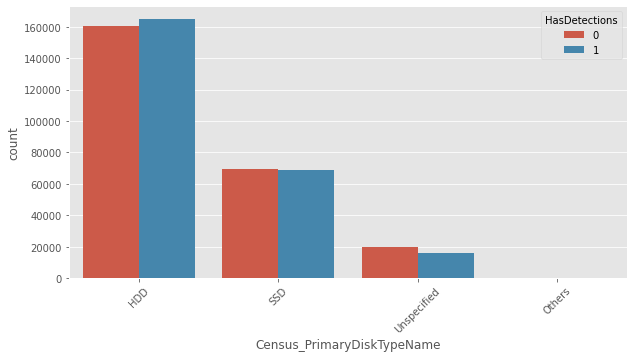

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x= 'Census_PrimaryDiskTypeName', hue = TARGET)
plt.xticks(rotation=45)

#####**Census_SystemVolumeTotalCapacity**

###### Con esta variable categorica podriamos agrupar primero por minorias, pero vemos que hay muchas etiquetas con valores muy bajos distribuidos, entiendo que no aporta mucho valor, procedo a elimarla.

In [ ]:
df['Census_SystemVolumeTotalCapacity'].value_counts(dropna=False)

NaN         2976
28542.0     2922
926992.0    2866
476389.0    2380
476324.0    2306
            ... 
221517.0       1
580181.0       1
127615.0       1
236484.0       1
470309.0       1
Name: Census_SystemVolumeTotalCapacity, Length: 142052, dtype: int64

In [ ]:
get_num_values(df,'Census_SystemVolumeTotalCapacity')

0

In [ ]:
df.drop('Census_SystemVolumeTotalCapacity', axis=1, inplace=True)

#####**Census_HasOpticalDiskDrive**

###### Esta variable boobleana podemos analizarla más en detalle para corroborar si tiene influencia la antiguedad de los equipos

In [ ]:
df['Census_HasOpticalDiskDrive'].value_counts(dropna=False)

0    461483
1     38517
Name: Census_HasOpticalDiskDrive, dtype: int64

In [ ]:
# Podemos asumir que los equipos con OpticalDisk son hardware mas antiguo, por lo que tiene sentido que a mas antiguo el equipo mas probabilidad de infeccion

pivotTable_func('Census_HasOpticalDiskDrive', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_HasOpticalDiskDrive,,,
1,38517,20593,0.534647
0,461483,229360,0.497006


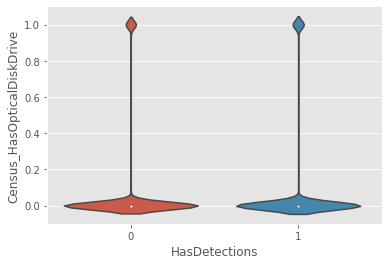

In [ ]:
sns.violinplot(data=df, x=TARGET, y='Census_HasOpticalDiskDrive')

Text(0.5, 1.0, 'Microsoft Malware Prediction')

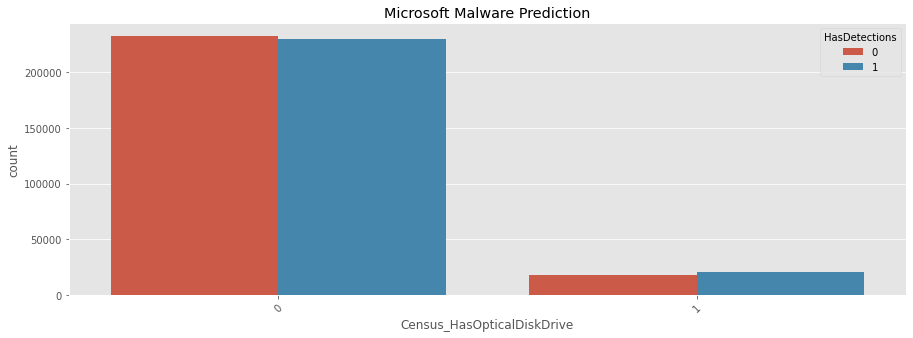

In [ ]:
plt.figure(figsize = (15,5))
sns.countplot(data = df, x= 'Census_HasOpticalDiskDrive', hue = TARGET)
plt.xticks(rotation=45)
plt.title('Microsoft Malware Prediction')

#####**Census_TotalPhysicalRAM**

###### Con esta variable podriamos entender que se trata del espacio de RAM del ordenador, pero al no estar 100% de los valores, vamos a proceder a agrupar minoritarios y luego un OHE

In [ ]:
df['Census_TotalPhysicalRAM'].value_counts(dropna=False)

4096.0     228678
8192.0     123174
2048.0      61694
16384.0     30179
6144.0      22349
            ...  
1279.0          1
2096.0          1
2064.0          1
2804.0          1
4120.0          1
Name: Census_TotalPhysicalRAM, Length: 553, dtype: int64

In [ ]:
df['Census_TotalPhysicalRAM'].isnull().sum()

4556

In [ ]:
df['Census_TotalPhysicalRAM'].fillna(value=-1, inplace=True)

In [ ]:
df['Census_TotalPhysicalRAM'].isnull().sum()

0

In [ ]:
pivotTable_func('Census_TotalPhysicalRAM', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_TotalPhysicalRAM,,,
11038.0,1,1,1.0
16382.0,1,1,1.0
3315.0,1,1,1.0
3359.0,1,1,1.0
10999.0,1,1,1.0
...,...,...,...
4047.0,6,0,0.0
4024.0,1,0,0.0


#####**Census_ChassisTypeName**

###### Con esta variable categorica podriamos agrupar primero por minorias y por etiquetas parecidas, y luego hacemos un Frequency Encoding

In [ ]:
df['Census_ChassisTypeName'].value_counts(dropna=False)

Notebook               294232
Desktop                104979
Laptop                  38261
Portable                20181
AllinOne                11407
MiniTower                4849
Convertible              4685
Other                    4215
UNKNOWN                  3695
Detachable               2930
LowProfileDesktop        2878
HandHeld                 2652
SpaceSaving              1689
Tablet                    730
Tower                     692
Unknown                   575
MainServerChassis         512
MiniPC                    261
LunchBox                  224
RackMountChassis          189
SubNotebook                47
BusExpansionChassis        38
NaN                        37
30                         11
StickPC                     7
0                           5
MultisystemChassis          3
35                          3
PizzaBox                    3
Blade                       3
31                          2
SubChassis                  2
32                          1
ExpansionC

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text major ticklabel objects>)

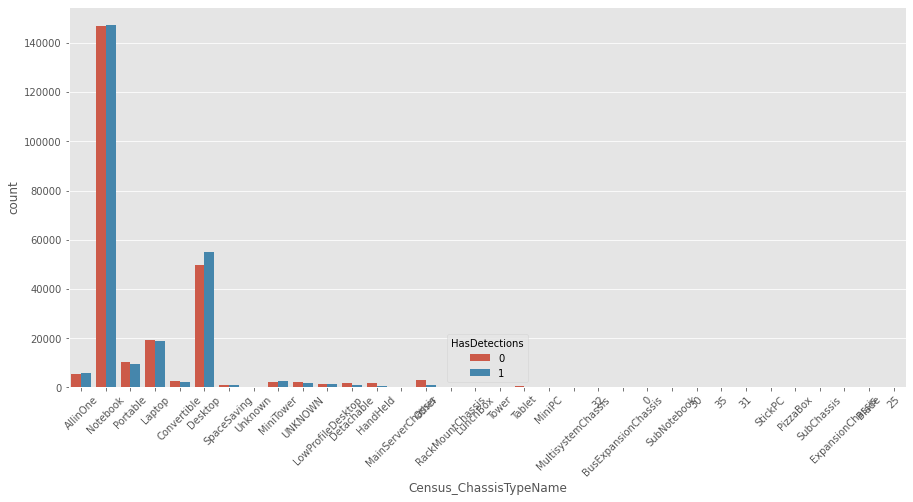

In [ ]:
# Aunque vemos etiquetas que parecieran tratarse de lo mismo, como Portable/Notebook/Laptop, no las agrupare, ya que veo que el comportamiento vs el TARGET es levemente distinto, y prefiero dejarlo para 
# que el DT decida, si agrupare valores minoritarios y asignare valor extremo a los NaN
plt.figure(figsize = (15,7))
sns.countplot(data = df, x= 'Census_ChassisTypeName', hue = TARGET)
plt.xticks(rotation=45)

In [ ]:
get_num_values(df, 'Census_ChassisTypeName')

5

In [ ]:
# En este caso no me quedo con el valor que me da mi funcion de getValues, porque creo que es mejor dejarle mas etiquetas en esta variable, y aportar mayor informacion al DT
df['Census_ChassisTypeName'] =  set_Others(df, 'Census_ChassisTypeName', 13)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

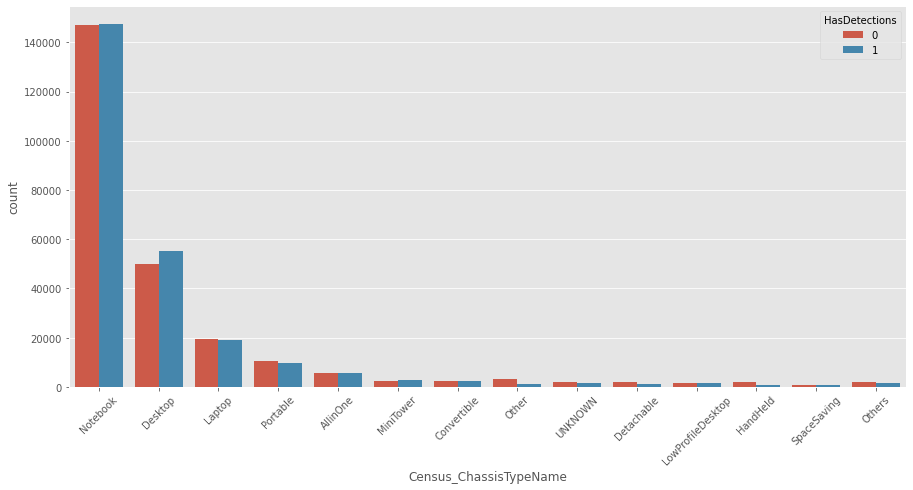

In [ ]:
plt.figure(figsize = (15,7))
sns.countplot(data = df, x= 'Census_ChassisTypeName', hue = TARGET)
plt.xticks(rotation=45)

In [ ]:
pivotTable_func('Census_ChassisTypeName', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_ChassisTypeName,,,
MiniTower,4849,2597,0.535574
Desktop,104979,55150,0.525343
LowProfileDesktop,2878,1481,0.514593
AllinOne,11407,5831,0.511177
Notebook,294232,147270,0.500523
Laptop,38261,18864,0.493035
Convertible,4685,2252,0.480683
Portable,20181,9696,0.480452


#####**Census_InternalPrimaryDiagonalDisplaySizeInInches**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un OHE

In [ ]:
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'].value_counts(dropna=False)

15.5    171319
13.9     52873
14.0     30492
11.6     17592
21.5     15441
         ...  
7.3          1
36.4         1
61.7         1
73.2         1
95.4         1
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, Length: 521, dtype: int64

In [ ]:
get_num_values(df, 'Census_InternalPrimaryDiagonalDisplaySizeInInches')

16

In [ ]:
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = set_Others_num(df, 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 16)

In [ ]:
pivotTable_func('Census_InternalPrimaryDiagonalDisplaySizeInInches', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_InternalPrimaryDiagonalDisplaySizeInInches,,,
27.0,5907,3395,0.574742
24.0,6822,3797,0.556582
21.5,15441,8293,0.537077
18.5,11751,6300,0.536125
23.0,10736,5654,0.526639
13.9,52873,27711,0.524105
15.6,10085,5236,0.519187
20.0,5940,3049,0.513300


#####**Census_InternalPrimaryDisplayResolutionHorizontal**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un OHE

In [ ]:
df['Census_InternalPrimaryDisplayResolutionHorizontal'].value_counts(dropna=False)

1366.0     251999
1920.0     125095
1280.0      29690
1600.0      28231
1024.0      19327
            ...  
6016.0          1
4288.0          1
1646.0          1
2528.0          1
10320.0         1
Name: Census_InternalPrimaryDisplayResolutionHorizontal, Length: 475, dtype: int64

In [ ]:
get_num_values(df, 'Census_InternalPrimaryDisplayResolutionHorizontal')

8

In [ ]:
df['Census_InternalPrimaryDisplayResolutionHorizontal'] = set_Others_num(df, 'Census_InternalPrimaryDisplayResolutionHorizontal', 8)

In [ ]:
pivotTable_func('Census_InternalPrimaryDisplayResolutionHorizontal', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_InternalPrimaryDisplayResolutionHorizontal,,,
1920.0,125095,66506,0.531644
1680.0,6234,3241,0.519891
1360.0,7058,3652,0.517427
1600.0,28231,14149,0.501187
1366.0,251999,126044,0.500177
1440.0,9441,4642,0.491685
-1.0,22925,10517,0.458757
1024.0,19327,8830,0.456874


#####**Census_InternalPrimaryDisplayResolutionVertical**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un OHE

In [ ]:
df['Census_InternalPrimaryDisplayResolutionVertical'].value_counts(dropna=False)

768.0     277762
1080.0    121145
900.0      36912
800.0      14687
1024.0     10603
           ...  
1960.0         1
1295.0         1
2286.0         1
880.0          1
1612.0         1
Name: Census_InternalPrimaryDisplayResolutionVertical, Length: 515, dtype: int64

In [ ]:
get_num_values(df, 'Census_InternalPrimaryDisplayResolutionVertical')

6

In [ ]:
df['Census_InternalPrimaryDisplayResolutionVertical'] = set_Others_num(df, 'Census_InternalPrimaryDisplayResolutionVertical', 6)

In [ ]:
pivotTable_func('Census_InternalPrimaryDisplayResolutionVertical', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_InternalPrimaryDisplayResolutionVertical,,,
1080.0,121145,65107,0.537430
1050.0,6397,3316,0.518368
900.0,36912,18427,0.499214
768.0,277762,138621,0.499064
1024.0,10603,5210,0.491370
-1.0,32494,14272,0.439220
800.0,14687,5000,0.340437


#####**Census_PowerPlatformRoleName**

###### Con esta variable categorica vamos rellenar NaN con valor extremo y luego OHE, ya que no veo etiquetas parecidas como para agrupa


In [ ]:
df['Census_PowerPlatformRoleName'].value_counts(dropna=False)

Mobile               346378
Desktop              116054
Slate                 27475
Workstation            6235
SOHOServer             2062
UNKNOWN                1172
EnterpriseServer        406
AppliancePC             212
PerformanceServer         4
NaN                       2
Name: Census_PowerPlatformRoleName, dtype: int64

In [ ]:
df['Census_PowerPlatformRoleName'].fillna(value='Others', inplace=True)

In [ ]:
# PerformanceServer tiene una media muy alta, pero el valor de observaciones no nos deja fiarnos de la misma, pero vemos que la media varia dentro del dataset
# Aqui podemos ver tambien que las observaciones desde Moviles pareciera tener menor impacto de infeccion, vs un desktop donde la probabilidad sube en 2 p.p.

pivotTable_func('Census_PowerPlatformRoleName', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_PowerPlatformRoleName,,,
PerformanceServer,4,3,0.750000
Desktop,116054,60942,0.525118
Workstation,6235,3198,0.512911
Mobile,346378,173910,0.502082
SOHOServer,2062,1024,0.496605
UNKNOWN,1172,571,0.487201
EnterpriseServer,406,177,0.435961
Slate,27475,10082,0.366952


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

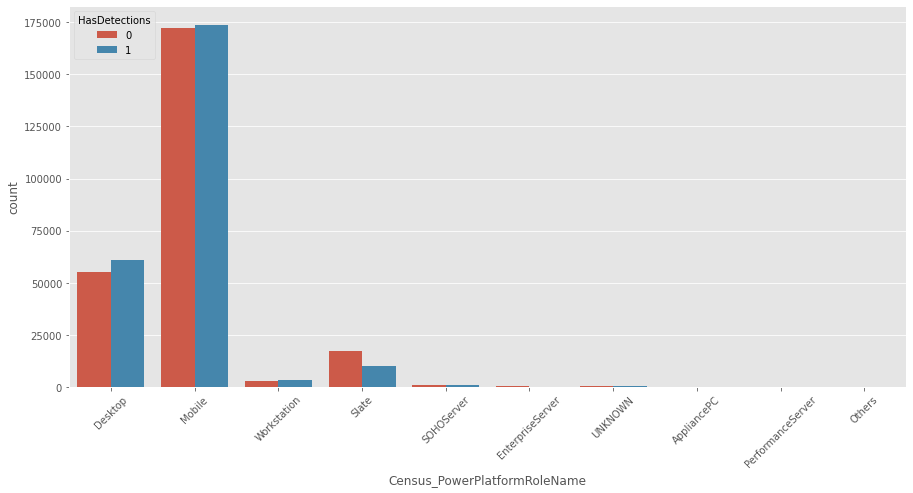

In [ ]:
# En el grafico se ve mejor la conclusion arriba mencionada 

plt.figure(figsize = (15,7))
sns.countplot(data = df, x= 'Census_PowerPlatformRoleName', hue = TARGET)
plt.xticks(rotation=45)

#####**Census_InternalBatteryType**

###### Esta variable tiene muchos nulos, no aporta mucho valor, por lo que procedemos a eliminarla

In [ ]:
df['Census_InternalBatteryType'].value_counts(dropna=False)

NaN     355603
lion    113500
li-i     13855
#        10176
lip       3326
liio      1814
li p       466
li         356
nimh       272
real       162
bq20       143
pbac       130
vbox        89
lgi0        29
unkn        19
lipo        13
lhp0        12
ithi         7
4cel         6
ram          5
lipp         3
batt         3
bad          3
virt         2
a132         2
lgl0         1
li-l         1
icp3         1
3ion         1
Name: Census_InternalBatteryType, dtype: int64

In [ ]:
df.drop('Census_InternalBatteryType',axis=1, inplace=True)

#####**Census_InternalBatteryNumberOfCharges**

###### Esta variable podriamos entenderla como la cantidad de veces que ha sido cargada la bateria del ordenador, solo impactaria en las notebooks/portatiles,etc. Vamos a rellenar los NaN con valor extremo

In [ ]:
df['Census_InternalBatteryNumberOfCharges'].value_counts(dropna=False)

0.000000e+00    283189
4.294967e+09    126436
NaN              15038
1.000000e+00      2955
1.600000e+01      1517
                 ...  
1.253000e+03         1
3.313400e+04         1
1.182000e+03         1
5.377000e+04         1
1.900000e+03         1
Name: Census_InternalBatteryNumberOfCharges, Length: 5249, dtype: int64

In [ ]:
df['Census_InternalBatteryNumberOfCharges'].fillna(-1, inplace = True)

In [ ]:
pivotTable_func('Census_InternalBatteryNumberOfCharges', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_InternalBatteryNumberOfCharges,,,
37680.0,1,1,1.0
27246.0,1,1,1.0
27090.0,1,1,1.0
1853.0,1,1,1.0
27106.0,1,1,1.0
...,...,...,...
25604.0,1,0,0.0
25607.0,1,0,0.0


#####**Census_OSVersion**

###### Esta variable se trata de versiones, por lo que podemos entender que tiene orden intrinseco, la dejamos como esta, ademas no tiene NaN

In [ ]:
df['Census_OSVersion'].value_counts(dropna=False)

10.0.17134.228     79975
10.0.17134.165     50511
10.0.16299.431     30519
10.0.17134.285     26289
10.0.17134.112     19501
                   ...  
10.0.18214.1000        1
10.0.15019.1000        1
10.0.14328.1000        1
10.0.10586.601         1
10.0.15048.0           1
Name: Census_OSVersion, Length: 305, dtype: int64

In [ ]:
df['Census_OSVersion'] = df['Census_OSVersion'].str.replace(".", "").astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
df['Census_OSVersion'].isnull().sum()

0

#####**Census_OSArchitecture**

###### Esta variable es parecida a Processor, pero no son valores iguales, mantenemos ambas y hacemos un OHE

In [ ]:
df['Census_OSArchitecture'].value_counts(dropna=False)

amd64    454435
x86       45551
arm64        14
Name: Census_OSArchitecture, dtype: int64

In [ ]:
df['Processor'].value_counts(dropna=False)

x64      454423
x86       45563
arm64        14
Name: Processor, dtype: int64

In [ ]:
# Hacemos una crosstab para ver que tienen valores algunos valores distintos

pd.crosstab(df['Processor'], df['Census_OSArchitecture'])

Census_OSArchitecture,amd64,arm64,x86
Processor,,,
arm64,0,14,0
x64,453967,0,456
x86,468,0,45095


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

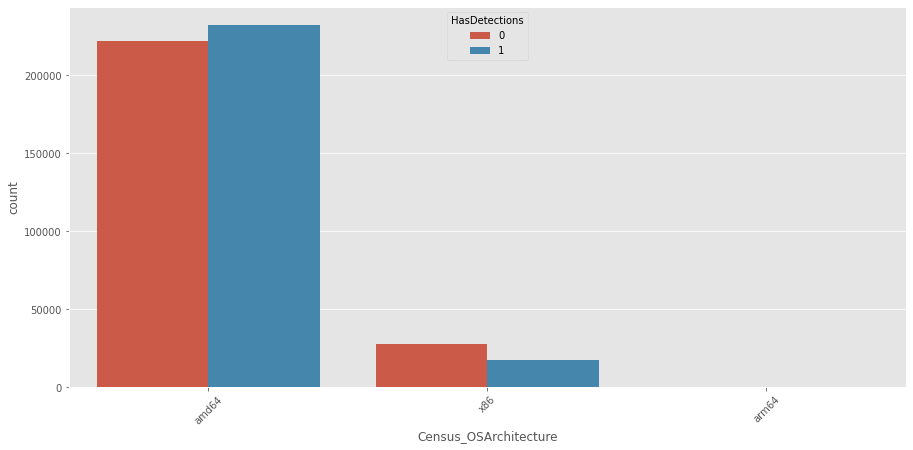

In [ ]:
# Pareciera tener infuecia el OSArchitecture en nuestro dataset
plt.figure(figsize = (15,7))
sns.countplot(data = df, x= 'Census_OSArchitecture', hue = TARGET)
plt.xticks(rotation=45)

#####**Census_OSBranch**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un OHE

In [ ]:
df['Census_OSBranch'].value_counts(dropna=False)

rs4_release                  226001
rs3_release                   69216
rs3_release_svc_escrow        67027
rs2_release                   44264
rs1_release                   43705
th2_release                   18298
th2_release_sec               14895
th1_st1                       10822
th1                            4284
rs5_release                     839
rs3_release_svc_escrow_im       329
rs_prerelease                   184
rs_prerelease_flt               132
rs5_release_sigma                 3
winblue_ltsb_escrow               1
Name: Census_OSBranch, dtype: int64

In [ ]:
#Agrupo etiquetas parecidas

df['Census_OSBranch'].replace('rs3_release_svc_escrow_im ', 'rs3_release', inplace=True)

In [ ]:
df['Census_OSBranch'].replace('rs3_release_svc_escrow', 'rs3_release', inplace=True)

In [ ]:
df['Census_OSBranch'].replace('th1_st1', 'th1', inplace=True)

In [ ]:
df['Census_OSBranch'].replace('th2_release_sec ', 'th2_release', inplace=True)

In [ ]:
df['Census_OSBranch'].replace('rs_prerelease_flt', 'rs_prerelease', inplace=True)

In [ ]:
df['Census_OSBranch'].replace('rs5_release_sigma', 'rs5_release', inplace=True)

In [ ]:
df['Census_OSBranch'].replace('rs5_release_sigma', 'rs5_release', inplace=True)

In [ ]:
pivotTable_func('Census_OSBranch', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_OSBranch,,,
rs4_release,226001,118008,0.522157
th2_release,18298,9022,0.493059
rs3_release,136243,66748,0.489919
th1,15106,7343,0.486098
rs2_release,44264,21230,0.479622
rs1_release,43705,20322,0.464981
rs_prerelease,316,145,0.458861
th2_release_sec,14895,6638,0.445653


#####**Census_OSBuildNumber**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un OHE

In [ ]:
df['Census_OSBuildNumber'].value_counts(dropna=False)

17134    225979
16299    136572
15063     44262
14393     43702
10586     33193
          ...  
9600          1
17074         1
17753         1
15042         1
15048         1
Name: Census_OSBuildNumber, Length: 61, dtype: int64

In [ ]:
get_num_values(df, 'Census_OSBuildNumber')

6

In [ ]:
df['Census_OSBuildNumber'] = set_Others_num(df, 'Census_OSBuildNumber', 6)

In [ ]:
pivotTable_func('Census_OSBuildNumber', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_OSBuildNumber,,,
17134,225979,117998,0.522164
16299,136572,66880,0.489705
10240,15106,7343,0.486098
15063,44262,21229,0.479621
10586,33193,15660,0.471786
14393,43702,20320,0.464967
-1,1186,523,0.440978


#####**Census_OSBuildRevision**

###### Con esta variable categorica podriamos hacer un Frequency Encoding, ya que no tenemos NaN, tampoco un orden intrinseco, y son muchas etiquetas para hacer un OHE
###### Luego de ver la matriz de correlacion vemos que tiene alta correlacion con la variable 'Census_OSVersion', procedemos a eliminarla

In [ ]:
df['Census_OSBuildRevision'].value_counts(dropna=False)

228      79975
165      50511
431      30519
285      26289
112      19503
         ...  
17643        1
1230         1
491          1
206          1
16399        1
Name: Census_OSBuildRevision, Length: 242, dtype: int64

In [ ]:
df.drop('Census_OSBuildRevision',axis=1, inplace=True)

#####**Census_OSEdition**

###### Con esta variable categorica podriamos agrupar primero por minorias/ etiquetas parecidas, y luego hacemos un OHE

In [ ]:
df['Census_OSEdition'].value_counts(dropna=False)

Core                        194469
Professional                175808
CoreSingleLanguage          108696
CoreCountrySpecific           9275
ProfessionalEducation         3100
Education                     2310
Enterprise                    2055
ProfessionalN                 1624
EnterpriseS                   1108
ServerStandard                 584
Cloud                          336
CoreN                          251
ServerStandardEval             151
EducationN                      61
ServerDatacenterEval            47
EnterpriseSN                    47
ServerSolution                  34
EnterpriseN                     28
ProfessionalEducationN          12
ProfessionalWorkstation          2
CloudN                           1
ProfessionalWorkstationN         1
Name: Census_OSEdition, dtype: int64

In [ ]:
df['Census_OSEdition'].replace('ProfessionalWorkstationN', 'ProfessionalWorkstation', inplace= True)

In [ ]:
df['Census_OSEdition'].replace('CloudN', 'Cloud', inplace= True)

In [ ]:
df['Census_OSEdition'].replace('ProfessionalN', 'Professional', inplace= True)

In [ ]:
df['Census_OSEdition'].replace('EnterpriseN', 'Enterprise', inplace= True)

In [ ]:
df['Census_OSEdition'].replace('EnterpriseSN', 'Enterprise', inplace= True)

In [ ]:
df['Census_OSEdition'].replace('EnterpriseS', 'Enterprise', inplace= True)

In [ ]:
df['Census_OSEdition'].replace('EducationN', 'Education', inplace= True)

In [ ]:
df['Census_OSEdition'].replace('ProfessionalEducationN', 'ProfessionalEducation', inplace= True)

In [ ]:
df['Census_OSEdition'].replace('ServerStandardEval', 'ServerStandard', inplace= True)

In [ ]:
df['Census_OSEdition'].value_counts(dropna=False)

Core                       194469
Professional               177432
CoreSingleLanguage         108696
CoreCountrySpecific          9275
Enterprise                   3238
ProfessionalEducation        3112
Education                    2371
ServerStandard                735
Cloud                         337
CoreN                         251
ServerDatacenterEval           47
ServerSolution                 34
ProfessionalWorkstation         3
Name: Census_OSEdition, dtype: int64

#####**Census_OSSkuName**

###### Con esta variable categorica podriamos agrupar primero por minorias/ etiquetas parecidas, y luego hacemos un OHE. De todas formas no vamos a agrupar, porque viendo la pivot etiquetas parecidas tienen un comportamiento distinto con el target

In [ ]:
df['Census_OSSkuName'].value_counts(dropna=False)

CORE                            194464
PROFESSIONAL                    178947
CORE_SINGLELANGUAGE             108674
CORE_COUNTRYSPECIFIC              9257
EDUCATION                         2313
ENTERPRISE                        2063
PROFESSIONAL_N                    1634
ENTERPRISE_S                      1107
STANDARD_SERVER                    584
CLOUD                              332
CORE_N                             251
STANDARD_EVALUATION_SERVER         151
EDUCATION_N                         61
ENTERPRISE_S_N                      48
DATACENTER_EVALUATION_SERVER        47
SB_SOLUTION_SERVER                  34
ENTERPRISE_N                        28
PRO_WORKSTATION                      2
CLOUDN                               1
PRO_WORKSTATION_N                    1
UNLICENSED                           1
Name: Census_OSSkuName, dtype: int64

In [ ]:
pivotTable_func('Census_OSSkuName', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_OSSkuName,,,
UNLICENSED,1,1,1.000000
PRO_WORKSTATION_N,1,1,1.000000
ENTERPRISE_S_N,48,35,0.729167
ENTERPRISE_N,28,16,0.571429
PROFESSIONAL_N,1634,875,0.535496
CORE_SINGLELANGUAGE,108674,57578,0.529823
ENTERPRISE_S,1107,583,0.526649
EDUCATION,2313,1213,0.524427


#####**Census_OSInstallTypeName**

###### Con esta variable categorica podriamos agrupar primero por minorias/ etiquetas parecidas, y luego hacemos un OHE. De todas formas no vamos a agrupar, porque viendo la pivot etiquetas parecidas tienen un comportamiento distinto con el target

In [ ]:
df['Census_OSInstallTypeName'].value_counts(dropna=False)

UUPUpgrade        146780
IBSClean           92403
Update             88892
Upgrade            70013
Other              46960
Reset              36510
Refresh            11540
Clean               3885
CleanPCRefresh      3017
Name: Census_OSInstallTypeName, dtype: int64

In [ ]:
pivotTable_func('Census_OSInstallTypeName', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_OSInstallTypeName,,,
UUPUpgrade,146780,77129,0.525473
Clean,3885,2032,0.523037
IBSClean,92403,48304,0.522754
Reset,36510,17605,0.482197
Update,88892,42499,0.478097
Other,46960,22409,0.477193
Upgrade,70013,33254,0.474969
CleanPCRefresh,3017,1395,0.462380


#####**Census_OSInstallLanguageIdentifier**

###### Primero rellenamos los NaN con  valor extrmo y luego hacemos un OHE

In [ ]:
df['Census_OSInstallLanguageIdentifier'].value_counts(dropna=False)

8.0     178405
9.0      58013
7.0      28766
29.0     27669
14.0     24191
37.0     22635
10.0     20268
26.0     18520
5.0      14085
35.0     11497
39.0     11221
18.0     10600
20.0      9512
24.0      8127
25.0      7502
27.0      5956
19.0      4775
17.0      4695
1.0       4516
3.0       4067
NaN       3332
6.0       2881
33.0      2807
15.0      2311
4.0       1996
30.0      1793
23.0      1652
31.0      1213
12.0      1119
2.0       1096
36.0       846
16.0       837
28.0       713
34.0       584
13.0       581
21.0       413
32.0       246
11.0       197
38.0       185
22.0       178
Name: Census_OSInstallLanguageIdentifier, dtype: int64

In [ ]:
df['Census_OSInstallLanguageIdentifier'].fillna(value=-1, inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text major ticklabel objects>)

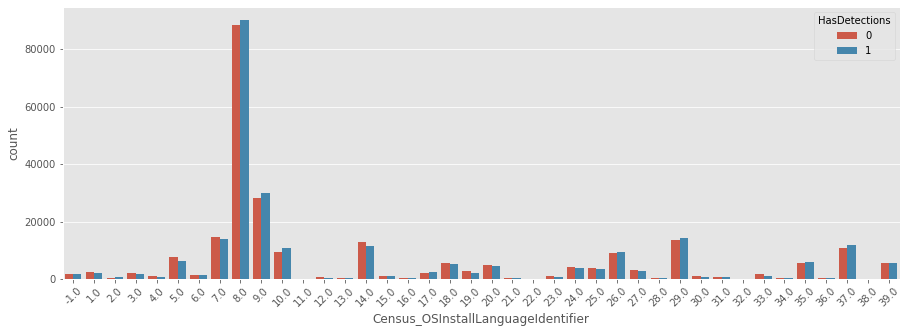

In [ ]:
plt.figure(figsize = (15,5))
sns.countplot(data = df, x= 'Census_OSInstallLanguageIdentifier', hue = TARGET)
plt.xticks(rotation=45)

#####**Census_OSUILocaleIdentifier**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un OHE

In [ ]:
df['Census_OSUILocaleIdentifier'].value_counts(dropna=False)

31     177983
34      58307
30      28798
125     28001
49      24423
        ...  
89          1
22          1
6           1
71          1
141         1
Name: Census_OSUILocaleIdentifier, Length: 92, dtype: int64

In [ ]:
df['Census_OSUILocaleIdentifier'].isnull().sum()

0

In [ ]:
get_num_values(df, 'Census_OSUILocaleIdentifier')

16

In [ ]:
df['Census_OSUILocaleIdentifier'] = set_Others_num(df, 'Census_OSUILocaleIdentifier', 16)

In [ ]:
pivotTable_func('Census_OSUILocaleIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_OSUILocaleIdentifier,,,
35,20890,11256,0.538822
158,22930,12002,0.523419
148,11617,6060,0.521649
34,58307,29943,0.513540
125,28001,14334,0.511910
119,18696,9556,0.511125
31,177983,89849,0.504818
160,11244,5613,0.499200


#####**Census_OSWUAutoUpdateOptionsName**

###### Con esta variable hacemos un OHE

In [ ]:
df['Census_OSWUAutoUpdateOptionsName'].value_counts(dropna=False)

FullAuto                                 222482
UNKNOWN                                  140961
Notify                                   113507
AutoInstallAndRebootAtMaintenanceTime     20731
Off                                        1506
DownloadNotify                              813
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64

#####**Census_IsPortableOperatingSystem**

###### Esta variable es booleana, de momento la dejamos como está

In [ ]:
df['Census_IsPortableOperatingSystem'].value_counts(dropna=False)

0    499739
1       261
Name: Census_IsPortableOperatingSystem, dtype: int64

In [ ]:
pivotTable_func('Census_IsPortableOperatingSystem', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_IsPortableOperatingSystem,,,
1,261,135,0.517241
0,499739,249818,0.499897


#####**Census_GenuineStateName**

###### Con esta variable hacemos un OHE

In [ ]:
df['Census_GenuineStateName'].value_counts(dropna=False)

IS_GENUINE         441402
INVALID_LICENSE     44990
OFFLINE             12834
UNKNOWN               774
Name: Census_GenuineStateName, dtype: int64

In [ ]:
pivotTable_func('Census_GenuineStateName', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_GenuineStateName,,,
OFFLINE,12834,6994,0.544959
IS_GENUINE,441402,220477,0.499493
INVALID_LICENSE,44990,22236,0.494243
UNKNOWN,774,246,0.317829


#####**Census_ActivationChannel**

###### Con esta variable categorica podriamos agrupar primero por minorias/ etiquetas parecidas, y luego hacemos un OHE. De todas formas no vamos a agrupar, porque viendo la pivot etiquetas parecidas tienen un comportamiento distinto con el target

In [ ]:
df['Census_ActivationChannel'].value_counts(dropna=False)

Retail            264932
OEM:DM            191350
Volume:GVLK        25109
OEM:NONSLP         17943
Volume:MAK           468
Retail:TB:Eval       198
Name: Census_ActivationChannel, dtype: int64

In [ ]:
pivotTable_func('Census_ActivationChannel', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_ActivationChannel,,,
Volume:GVLK,25109,14963,0.595922
OEM:NONSLP,17943,9314,0.519088
OEM:DM,191350,94880,0.495845
Retail,264932,130532,0.492700
Volume:MAK,468,212,0.452991
Retail:TB:Eval,198,52,0.262626


#####**Census_IsFlightingInternal**


###### Esta variable tiene muchos NaN procedemos a eliminar

In [ ]:
df['Census_IsFlightingInternal'].value_counts(dropna=False)

NaN    415225
0.0     84773
1.0         2
Name: Census_IsFlightingInternal, dtype: int64

In [ ]:
df.drop('Census_IsFlightingInternal',axis=1, inplace=True)

#####**Census_IsFlightsDisabled**

###### Esta variable tiene muchos NaN procedemos a eliminar

In [ ]:
df['Census_IsFlightsDisabled'].value_counts(dropna=False)

0.0    491060
NaN      8933
1.0         7
Name: Census_IsFlightsDisabled, dtype: int64

In [ ]:
df.drop('Census_IsFlightsDisabled',axis=1, inplace=True)

#####**Census_FlightRing**

###### Con esta variable hacemos un OHE

In [ ]:
df['Census_FlightRing'].value_counts(dropna=False)

Retail      468299
NOT_SET      16044
Unknown      13701
WIS            606
RP             583
WIF            549
Disabled       217
OSG              1
Name: Census_FlightRing, dtype: int64

In [ ]:
pivotTable_func('Census_FlightRing', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_FlightRing,,,
RP,583,299,0.512864
Retail,468299,234693,0.501161
NOT_SET,16044,7980,0.497382
Unknown,13701,6378,0.465513
WIF,549,253,0.460838
Disabled,217,100,0.460829
WIS,606,250,0.412541
OSG,1,0,0.000000


#####**Census_ThresholdOptIn**

###### Esta variable tiene muchos NaN procedemos a eliminar

In [ ]:
df['Census_ThresholdOptIn'].value_counts(dropna=False)

NaN    318104
0.0    181849
1.0        47
Name: Census_ThresholdOptIn, dtype: int64

In [ ]:
df.drop('Census_ThresholdOptIn',axis=1, inplace=True)

#####**Census_FirmwareManufacturerIdentifier**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un OHE

In [ ]:
df['Census_FirmwareManufacturerIdentifier'].value_counts(dropna=False)

142.0    151374
628.0     68781
554.0     65673
355.0     52758
556.0     44919
          ...  
33.0          1
697.0         1
13.0          1
334.0         1
585.0         1
Name: Census_FirmwareManufacturerIdentifier, Length: 304, dtype: int64

In [ ]:
get_num_values(df, 'Census_FirmwareManufacturerIdentifier')

13

In [ ]:
len(df['Census_FirmwareManufacturerIdentifier'].value_counts().index[df['Census_FirmwareManufacturerIdentifier'].value_counts().values == 1])

93

In [ ]:
df['Census_FirmwareManufacturerIdentifier'] = set_Others_num(df, 'Census_FirmwareManufacturerIdentifier', 13)

In [ ]:
pivotTable_func('Census_FirmwareManufacturerIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_FirmwareManufacturerIdentifier,,,
93.0,10666,5582,0.523345
142.0,151374,78575,0.519079
355.0,52758,26942,0.510671
554.0,65673,33489,0.509936
556.0,44919,22664,0.504553
628.0,68781,34370,0.499702
486.0,6060,3015,0.497525
807.0,8803,4257,0.483585


#####**Census_FirmwareVersionIdentifier**

###### Con esta variable categorica podriamos agrupar primero por minorias, y luego hacemos un Frequency Encoding

In [ ]:
df['Census_FirmwareVersionIdentifier'].value_counts(dropna=False)

NaN        9061
33105.0    5036
33111.0    3356
33054.0    3124
33108.0    3071
           ... 
41482.0       1
41752.0       1
20762.0       1
15577.0       1
54497.0       1
Name: Census_FirmwareVersionIdentifier, Length: 23570, dtype: int64

In [ ]:
(df['Census_FirmwareVersionIdentifier'].isnull().sum()/len(df['Census_FirmwareVersionIdentifier']))*100

1.8121999999999998

In [ ]:
df['Census_FirmwareVersionIdentifier'].max()

72091.0

In [ ]:
df['Census_FirmwareVersionIdentifier'].fillna(value=-1, inplace=True)

In [ ]:
df['Census_FirmwareVersionIdentifier'].isnull().sum()

0

In [ ]:
pivotTable_func('Census_FirmwareVersionIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_FirmwareVersionIdentifier,,,
38127.0,1,1,1.0
29987.0,1,1,1.0
29957.0,1,1,1.0
29959.0,3,3,1.0
29971.0,1,1,1.0
...,...,...,...
18366.0,1,0,0.0
18382.0,1,0,0.0


#####**Census_IsSecureBootEnabled**

###### Esta variable es booleana, de momento la dejamos como está

In [ ]:
df['Census_IsSecureBootEnabled'].value_counts(dropna=False)

0    257281
1    242719
Name: Census_IsSecureBootEnabled, dtype: int64

In [ ]:
pivotTable_func('Census_IsSecureBootEnabled', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_IsSecureBootEnabled,,,
0,257281,128927,0.501114
1,242719,121026,0.498626


#####**Census_IsWIMBootEnabled**

###### Esta variable tiene muchos NaN procedemos a eliminar

In [ ]:
df['Census_IsWIMBootEnabled'].value_counts(dropna=False)

NaN    317666
0.0    182334
Name: Census_IsWIMBootEnabled, dtype: int64

In [ ]:
df.drop('Census_IsWIMBootEnabled',axis=1, inplace=True)

#####**Census_IsVirtualDevice**

###### Primero rellenamos los NaN con 0, asumiendo mismo criterio que para la variable isProtected y luego queda como Boolean

In [ ]:
df['Census_IsVirtualDevice'].value_counts(dropna=False)

0.0    495572
1.0      3527
NaN       901
Name: Census_IsVirtualDevice, dtype: int64

In [ ]:
pivotTable_func('Census_IsVirtualDevice', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_IsVirtualDevice,,,
0.0,495572,248769,0.501984
1.0,3527,712,0.201871


In [ ]:
df['Census_IsVirtualDevice'].fillna(value=0, inplace=True)

In [ ]:
pivotTable_func('Census_IsVirtualDevice', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_IsVirtualDevice,,,
0.0,496473,249241,0.502023
1.0,3527,712,0.201871


#####**Census_IsTouchEnabled**

###### Esta variable es booleana, de momento la dejamos como está. La misma pareciera tener influencia vs target

In [ ]:
df['Census_IsTouchEnabled'].value_counts(dropna=False)

0    437283
1     62717
Name: Census_IsTouchEnabled, dtype: int64

In [ ]:
pivotTable_func('Census_IsTouchEnabled', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_IsTouchEnabled,,,
0,437283,221964,0.507598
1,62717,27989,0.446275


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

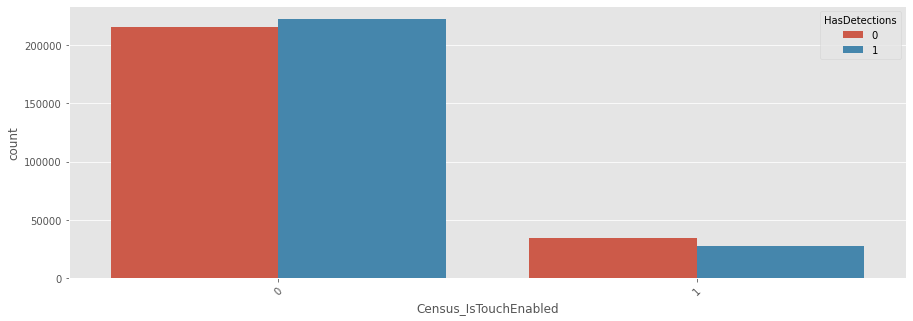

In [ ]:
plt.figure(figsize = (15,5))
sns.countplot(data = df, x= 'Census_IsTouchEnabled', hue = TARGET)
plt.xticks(rotation=45)

#####**Census_IsPenCapable**

###### Esta variable es booleana, de momento la dejamos como está

In [ ]:
df['Census_IsPenCapable'].value_counts(dropna=False)

0    481128
1     18872
Name: Census_IsPenCapable, dtype: int64

In [ ]:
pivotTable_func('Census_IsPenCapable', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_IsPenCapable,,,
0,481128,241323,0.501578
1,18872,8630,0.457291


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

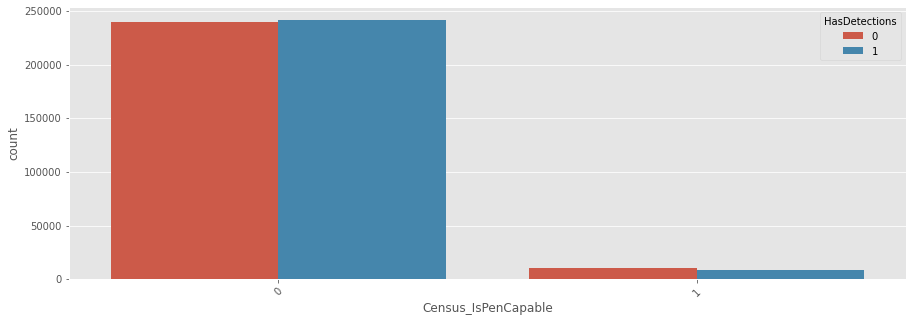

In [ ]:
plt.figure(figsize = (15,5))
sns.countplot(data = df, x= 'Census_IsPenCapable', hue = TARGET)
plt.xticks(rotation=45)

#####**Census_IsAlwaysOnAlwaysConnectedCapable**

###### Primero rellenamos los NaN con 0, asumiendo mismo criterio que para la variable isProtected y luego queda como Boolean

In [ ]:
df['Census_IsAlwaysOnAlwaysConnectedCapable'].value_counts(dropna=False)

0.0    467569
1.0     28391
NaN      4040
Name: Census_IsAlwaysOnAlwaysConnectedCapable, dtype: int64

In [ ]:
pivotTable_func('Census_IsAlwaysOnAlwaysConnectedCapable', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_IsAlwaysOnAlwaysConnectedCapable,,,
0.0,467569,237317,0.507555
1.0,28391,10553,0.371702


In [ ]:
df['Census_IsAlwaysOnAlwaysConnectedCapable'].fillna(value=0, inplace=True)

In [ ]:
# Corroboramos que la media no se ve afectada en la etiqueta 0

pivotTable_func('Census_IsAlwaysOnAlwaysConnectedCapable', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Census_IsAlwaysOnAlwaysConnectedCapable,,,
0.0,471609,239400,0.507624
1.0,28391,10553,0.371702


#####**Wdft_IsGamer**

###### Primero rellenamos los NaN con 0 y luego queda como Boolean. Esta variable parece tener un rol importante, tiene sentido que los ordenadores Gamers sean utilizados para un proposito en particular y los sitios web buscados/utilizados tenga mayor probabilidad de infeccion

In [ ]:
df['Wdft_IsGamer'].value_counts(dropna=False)

0.0    345835
1.0    137215
NaN     16950
Name: Wdft_IsGamer, dtype: int64

In [ ]:
pivotTable_func('Wdft_IsGamer', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Wdft_IsGamer,,,
1.0,137215,74678,0.544241
0.0,345835,166416,0.481201


In [ ]:
df['Wdft_IsGamer'].fillna(value=0, inplace=True)

In [ ]:
# Corroboramos que la media no se ve afectada en la etiqueta 0

pivotTable_func('Wdft_IsGamer', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Wdft_IsGamer,,,
1.0,137215,74678,0.544241
0.0,362785,175275,0.483137


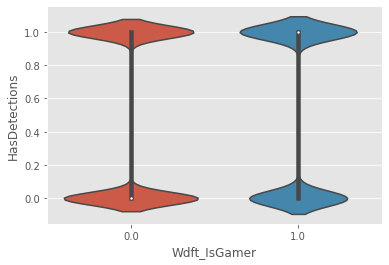

In [ ]:
sns.violinplot(x='Wdft_IsGamer', y=TARGET, data=df)

#####**Wdft_RegionIdentifier**

###### Primero rellenamos los NaN con la MODA y luego hacer un OHE

In [ ]:
df['Wdft_RegionIdentifier'].value_counts(dropna=False)

10.0    100392
11.0     75612
3.0      73069
1.0      68692
15.0     57346
7.0      33362
NaN      16950
8.0      15761
13.0     12681
5.0      11466
12.0      9115
6.0       8750
4.0       7586
9.0       4521
2.0       4470
14.0       227
Name: Wdft_RegionIdentifier, dtype: int64

In [ ]:
df['Wdft_RegionIdentifier'].fillna(value=-1, inplace=True)

In [ ]:
pivotTable_func('Wdft_RegionIdentifier', df)

,len,sum,mean
,HasDetections,HasDetections,HasDetections
Wdft_RegionIdentifier,,,
14.0,227,128,0.563877
1.0,68692,36762,0.535171
-1.0,16950,8859,0.522655
10.0,100392,51294,0.510937
11.0,75612,37981,0.502314
7.0,33362,16750,0.502068
3.0,73069,35898,0.491289
8.0,15761,7732,0.490578


#### 3.2 - Transformación de atributos

In [ ]:
# Controlamos el shape de nuestro DF y a su vez que no tengamos NaN en las categoricas/numericas

df.shape

(500000, 68)

In [ ]:
df.select_dtypes(include = np.number).isnull().sum()

EngineVersion                              0
AppVersion                                 0
AvSigVersion                               0
RtpStateBitfield                           0
IsSxsPassiveMode                           0
AVProductsInstalled                        0
AVProductsEnabled                          0
HasTpm                                     0
CountryIdentifier                          0
CityIdentifier                             0
OsVer                                      0
OsSuite                                    0
IsProtected                                0
Firewall                                   0
UacLuaenable                               0
Census_ProcessorCoreCount                  0
Census_ProcessorManufacturerIdentifier     0
Census_PrimaryDiskTotalCapacity            0
Census_HasOpticalDiskDrive                 0
Census_TotalPhysicalRAM                    0
Census_InternalBatteryNumberOfCharges      0
Census_OSVersion                           0
Census_OSI

In [ ]:
df.select_dtypes(exclude = np.number).isnull().sum()

ProductName                                          0
AVProductStatesIdentifier                            0
OrganizationIdentifier                               0
GeoNameIdentifier                                    0
LocaleEnglishNameIdentifier                          0
Platform                                             0
Processor                                            0
OsBuild                                              0
OsPlatformSubRelease                                 0
OsBuildLab                                           0
SkuEdition                                           0
IeVerIdentifier                                      0
SmartScreen                                          0
Census_MDC2FormFactor                                0
Census_OEMNameIdentifier                             0
Census_OEMModelIdentifier                            0
Census_ProcessorModelIdentifier                      0
Census_PrimaryDiskTypeName                           0
Census_Cha

In [ ]:
#Vamos a crear las listas para su transformacion
lista_booleanas = [ 'IsSxsPassiveMode','HasTpm','IsProtected','Firewall','Census_HasOpticalDiskDrive','Census_IsPortableOperatingSystem',
                   'Census_IsSecureBootEnabled','Census_IsVirtualDevice','Census_IsTouchEnabled','Census_IsPenCapable',
                   'Census_IsAlwaysOnAlwaysConnectedCapable','Wdft_IsGamer',
                   ]

In [ ]:
lista_cat_boolean = ['ProductName']

In [ ]:
lista_OHE = ['RtpStateBitfield','AVProductStatesIdentifier','AVProductsEnabled','OrganizationIdentifier','GeoNameIdentifier',
             'LocaleEnglishNameIdentifier','Platform','Processor','OsBuild','OsSuite','OsPlatformSubRelease','OsBuildLab','SkuEdition',
             'IeVerIdentifier','SmartScreen','UacLuaenable','Census_MDC2FormFactor','Census_OEMNameIdentifier','Census_OEMModelIdentifier',
              'Census_ProcessorManufacturerIdentifier','Census_ProcessorModelIdentifier','Census_PrimaryDiskTypeName','Census_ChassisTypeName','Census_InternalPrimaryDiagonalDisplaySizeInInches','Census_InternalPrimaryDisplayResolutionHorizontal',
             'Census_InternalPrimaryDisplayResolutionVertical','Census_PowerPlatformRoleName','Census_OSArchitecture','Census_OSBranch','Census_OSBuildNumber','Census_OSEdition',
             'Census_OSSkuName','Census_OSInstallTypeName','Census_OSInstallLanguageIdentifier','Census_OSUILocaleIdentifier','Census_OSWUAutoUpdateOptionsName','Census_GenuineStateName',
             'Census_ActivationChannel','Census_FlightRing','Census_FirmwareManufacturerIdentifier','Wdft_RegionIdentifier']

In [ ]:
lista_freqencoding = ['CountryIdentifier','CityIdentifier']

In [ ]:
lista_order = ['EngineVersion','AppVersion','AvSigVersion','AVProductsInstalled','OsVer','Census_ProcessorCoreCount','Census_PrimaryDiskTotalCapacity','Census_TotalPhysicalRAM','Census_InternalBatteryNumberOfCharges','Census_OSVersion','Census_FirmwareVersionIdentifier']

In [ ]:
corr = df.corr()

In [ ]:
# Chequemos la correlacion entre variables, y a simple vista aparece que Census_OSVersion y Census_OSBuildRevision explican lo mismo
# Decidir con cual nos quedamos

corr.style.background_gradient(cmap='coolwarm')

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OsVer,OsSuite,IsProtected,Firewall,UacLuaenable,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_PrimaryDiskTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSInstallLanguageIdentifier,Census_IsPortableOperatingSystem,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
EngineVersion,1.000000,-0.044587,0.107993,0.021131,0.004998,-0.114737,-0.031746,-0.002800,0.011738,0.003517,-0.003732,-0.046198,0.227436,-0.008840,0.000124,0.048491,0.012447,-0.015001,-0.002041,0.054028,0.050621,-0.016808,0.019956,0.004340,-0.016124,-0.043709,0.007377,0.004782,0.014107,0.009477,0.066462,0.003814,0.052042
AppVersion,-0.044587,1.000000,0.000109,0.004486,-0.002868,0.023291,-0.014208,0.061607,0.003789,-0.001783,0.026748,0.021449,-0.112834,0.039686,-0.000856,-0.041981,0.000614,-0.006969,0.016264,-0.038995,-0.025524,-0.019711,0.002598,-0.001692,0.012188,0.006242,0.002886,0.015530,0.005442,0.015750,-0.066416,0.033976,-0.076751
AvSigVersion,0.107993,0.000109,1.000000,-0.004739,0.006522,-0.012640,-0.000121,-0.000464,0.003012,0.002476,-0.002419,-0.012101,0.042055,0.001999,-0.001286,0.012426,0.004572,-0.003670,0.002327,0.013997,0.010830,-0.003887,0.002344,0.001128,-0.004456,-0.009764,-0.001118,-0.001003,-0.001788,0.001010,0.019687,0.021697,0.011105
RtpStateBitfield,0.021131,0.004486,-0.004739,1.000000,-0.800134,-0.169408,0.008579,-0.001669,0.012474,-0.002525,0.005108,-0.009249,0.069634,0.003725,0.000229,-0.017056,0.001662,-0.023936,-0.008208,-0.020936,-0.001945,0.017672,-0.015018,0.000439,0.002990,-0.014746,0.009421,0.009121,0.006580,0.018411,-0.017737,-0.000427,0.039216
IsSxsPassiveMode,0.004998,-0.002868,0.006522,-0.800134,1.000000,0.193148,0.028967,0.013870,-0.011686,0.001200,0.005637,0.016242,-0.030222,0.005568,-0.000187,0.023791,0.002287,0.022061,0.010481,0.027796,0.002351,-0.024474,0.012323,-0.001009,-0.005109,0.020660,-0.010613,-0.005630,-0.003095,-0.015702,0.032749,0.005401,-0.034038
AVProductsInstalled,-0.114737,0.023291,-0.012640,-0.169408,0.193148,1.000000,0.318986,0.028885,-0.022767,0.006549,0.007112,0.181638,0.015911,0.016186,-0.000861,-0.053002,-0.014445,0.105903,0.028971,-0.040966,-0.085988,-0.019760,0.009896,-0.007281,0.049317,0.212307,-0.063054,-0.012216,-0.027040,-0.066413,0.030931,0.057827,-0.144367
AVProductsEnabled,-0.031746,-0.014208,-0.000121,0.008579,0.028967,0.318986,1.000000,-0.033795,-0.015900,0.005327,-0.029380,0.036206,0.164417,-0.007043,-0.000133,-0.018452,-0.005838,0.014859,0.002088,-0.026207,-0.025497,0.010590,0.031616,-0.001660,-0.001118,0.036325,-0.055202,-0.000034,-0.005735,-0.013926,-0.001749,0.009002,-0.033887
HasTpm,-0.002800,0.061607,-0.000464,-0.001669,0.013870,0.028885,-0.033795,1.000000,0.004655,-0.006155,0.138067,0.025699,-0.000425,0.467010,0.000159,0.027315,0.007735,0.008973,0.005763,0.024988,0.049973,0.019667,-0.006147,-0.053331,0.008332,0.087262,0.002172,0.028685,0.016639,0.026462,0.062501,-0.014404,0.007198
CountryIdentifier,0.011738,0.003789,0.003012,0.012474,-0.011686,-0.022767,-0.015900,0.004655,1.000000,-0.006211,0.004786,-0.002216,-0.009876,-0.004239,-0.000315,0.012313,0.008805,-0.011081,0.008757,-0.006005,-0.001096,-0.003969,0.100815,0.000089,0.022053,-0.010436,-0.006406,0.004872,-0.011341,-0.008289,0.016635,-0.108228,0.006652
CityIdentifier,0.003517,-0.001783,0.002476,-0.002525,0.001200,0.006549,0.005327,-0.006155,-0.006211,1.000000,-0.001187,0.005112,0.008334,-0.002173,-0.002174,0.000847,-0.010745,-0.021002,0.006876,0.010641,0.011571,-0.013198,0.078086,0.002932,0.016436,0.008636,0.004422,-0.010654,-0.000002,0.000869,0.001910,-0.048156,-0.005497


In [ ]:
# Vamos a crear la copia de nuestro DF antes de comenzar con el tratamiento de las variable

df_final = df.copy()

In [ ]:
df_final.shape

(500000, 68)

#### 3.2 - Transformacion de variables

###### **OHE**

In [ ]:
# Vamos a definir la funcion para hacer el tratamiento del OHE

def OHE(dataframe, col_name):
  _dummy_dataset = pd.get_dummies(dataframe[col_name], prefix = col_name)
  dataframe = pd.concat([dataframe,_dummy_dataset], axis = 1)
  return dataframe.drop([col_name], axis =1)

In [ ]:
# Vamos a hacer un for i para que la funcion se ejecute en todas las columnas de la lista de OHE

for i in lista_OHE:
  num_etiquetas = len(df_final[i].value_counts())
  print(num_etiquetas)
  print(i)
  df_final = OHE(df_final, i)

8
RtpStateBitfield
9
AVProductStatesIdentifier
5
AVProductsEnabled
4
OrganizationIdentifier
28
GeoNameIdentifier
25
LocaleEnglishNameIdentifier
4
Platform
3
Processor
9
OsBuild
9
OsSuite
9
OsPlatformSubRelease
10
OsBuildLab
8
SkuEdition
14
IeVerIdentifier
10
SmartScreen
5
UacLuaenable
12
Census_MDC2FormFactor
15
Census_OEMNameIdentifier
5
Census_OEMModelIdentifier
5
Census_ProcessorManufacturerIdentifier
17
Census_ProcessorModelIdentifier
4
Census_PrimaryDiskTypeName
14
Census_ChassisTypeName
17
Census_InternalPrimaryDiagonalDisplaySizeInInches
9
Census_InternalPrimaryDisplayResolutionHorizontal
7
Census_InternalPrimaryDisplayResolutionVertical
10
Census_PowerPlatformRoleName
3
Census_OSArchitecture
11
Census_OSBranch
7
Census_OSBuildNumber
13
Census_OSEdition
21
Census_OSSkuName
9
Census_OSInstallTypeName
40
Census_OSInstallLanguageIdentifier
17
Census_OSUILocaleIdentifier
6
Census_OSWUAutoUpdateOptionsName
4
Census_GenuineStateName
6
Census_ActivationChannel
8
Census_FlightRing
14
Ce

In [ ]:
df_final.shape

(500000, 477)

##### **Frequency Encoding**

###### Vamos a hacer FE solamente para las variables de CountryIdentifier y CityIdentifier

In [ ]:
df_CountryIdentifier = pd.DataFrame(df['CountryIdentifier'].value_counts(dropna = False))
df_CountryIdentifier.columns = ['CountryIdentifier_COUNT']
df_CountryIdentifier['CountryIdentifier'] = df_CountryIdentifier.index

#Este es el dataframe que contiene el conteo de ciudades
df_CountryIdentifier.head()

df_final = df_final.merge(df_CountryIdentifier, on = 'CountryIdentifier')

#podemos eliminar la variable original ya que es categórica y ya hemos hecho el tratamiento pertinente
df_final.drop('CountryIdentifier', axis = 1, inplace = True)

In [ ]:
df_CityIdentifier = pd.DataFrame(df['CityIdentifier'].value_counts(dropna = False))
df_CityIdentifier.columns = ['CityIdentifier_COUNT']
df_CityIdentifier['CityIdentifier'] = df_CityIdentifier.index

#Este es el dataframe que contiene el conteo de ciudades
df_CityIdentifier.head()

df_final = df_final.merge(df_CityIdentifier, on = 'CityIdentifier')

#podemos eliminar la variable original ya que es categórica y ya hemos hecho el tratamiento pertinente
df_final.drop('CityIdentifier', axis = 1, inplace = True)

##### **Boolean categorica**

In [ ]:
df_final = pd.get_dummies (data=df_final,columns=lista_cat_boolean)

del (df_final["ProductName_mse"]) #borro las que son inversamente proporcional (las booleanas)

In [ ]:
df_final.head ()

,EngineVersion,AppVersion,AvSigVersion,IsSxsPassiveMode,AVProductsInstalled,HasTpm,OsVer,IsProtected,Firewall,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_IsPortableOperatingSystem,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,HasDetections,RtpStateBitfield_-1.0,RtpStateBitfield_0.0,RtpStateBitfield_1.0,RtpStateBitfield_3.0,RtpStateBitfield_5.0,RtpStateBitfield_7.0,RtpStateBitfield_8.0,RtpStateBitfield_35.0,AVProductStatesIdentifier_53447.0,AVProductStatesIdentifier_7945.0,AVProductStatesIdentifier_47238.0,AVProductStatesIdentifier_62773.0,AVProductStatesIdentifier_46413.0,AVProductStatesIdentifier_23657.0,AVProductStatesIdentifier_49480.0,AVProductStatesIdentifier_41571.0,...,Census_FlightRing_NOT_SET,Census_FlightRing_OSG,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIF,Census_FlightRing_WIS,Census_FirmwareManufacturerIdentifier_142.0,Census_FirmwareManufacturerIdentifier_628.0,Census_FirmwareManufacturerIdentifier_554.0,Census_FirmwareManufacturerIdentifier_355.0,Census_FirmwareManufacturerIdentifier_556.0,Census_FirmwareManufacturerIdentifier_500.0,Census_FirmwareManufacturerIdentifier_93.0,Census_FirmwareManufacturerIdentifier_807.0,Census_FirmwareManufacturerIdentifier_513.0,Census_FirmwareManufacturerIdentifier_127.0,Census_FirmwareManufacturerIdentifier_486.0,Census_FirmwareManufacturerIdentifier_897.0,Census_FirmwareManufacturerIdentifier_512.0,Census_FirmwareManufacturerIdentifier_-1.0,Wdft_RegionIdentifier_-1.0,Wdft_RegionIdentifier_1.0,Wdft_RegionIdentifier_2.0,Wdft_RegionIdentifier_3.0,Wdft_RegionIdentifier_4.0,Wdft_RegionIdentifier_5.0,Wdft_RegionIdentifier_6.0,Wdft_RegionIdentifier_7.0,Wdft_RegionIdentifier_8.0,Wdft_RegionIdentifier_9.0,Wdft_RegionIdentifier_10.0,Wdft_RegionIdentifier_11.0,Wdft_RegionIdentifier_12.0,Wdft_RegionIdentifier_13.0,Wdft_RegionIdentifier_14.0,Wdft_RegionIdentifier_15.0,CountryIdentifier_COUNT,CityIdentifier_COUNT,ProductName_win8defender
0,11151001,418180718075,127312340,0,1.0,1,10000,1.0,1.0,4.0,953869.0,0,8192.0,4.294967e+09,10017134165,0,19951.0,0,0.0,0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1
1,11151001,418180618062,12732860,0,1.0,1,10000,1.0,1.0,2.0,476940.0,0,2048.0,4.294967e+09,10017134165,0,19251.0,0,0.0,0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1
2,11151001,418180718075,127311650,0,2.0,1,10000,0.0,1.0,4.0,476940.0,0,4096.0,0.000000e+00,10014393105,0,33105.0,1,0.0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1
3,11152001,4102090,127512090,0,1.0,0,6110,1.0,1.0,4.0,305245.0,0,4096.0,0.000000e+00,1001058629,0,14738.0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,0
4,11152001,418180718075,12754230,0,2.0,1,10000,1.0,1.0,4.0,476940.0,0,4096.0,4.294967e+09,10017134228,0,33154.0,1,0.0,0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1


##### **Orden Intrinseco**

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

def ord_encode(df, column):
  enc = OrdinalEncoder()
  # transforming the column after fitting
  enc = enc.fit_transform(df[[column]])
  # concating dataframes 
  df[column]= enc
  # removing the encoded column.
  return df 

In [ ]:
for i in lista_order:
  num_etiquetas = len(df_final[i].value_counts())
  print(num_etiquetas)
  print(i)
  df_final = ord_encode(df_final, i)

In [ ]:
df_final.head()

,EngineVersion,AppVersion,AvSigVersion,IsSxsPassiveMode,AVProductsInstalled,HasTpm,OsVer,IsProtected,Firewall,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_IsPortableOperatingSystem,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,HasDetections,RtpStateBitfield_-1.0,RtpStateBitfield_0.0,RtpStateBitfield_1.0,RtpStateBitfield_3.0,RtpStateBitfield_5.0,RtpStateBitfield_7.0,RtpStateBitfield_8.0,RtpStateBitfield_35.0,AVProductStatesIdentifier_53447.0,AVProductStatesIdentifier_7945.0,AVProductStatesIdentifier_47238.0,AVProductStatesIdentifier_62773.0,AVProductStatesIdentifier_46413.0,AVProductStatesIdentifier_23657.0,AVProductStatesIdentifier_49480.0,AVProductStatesIdentifier_41571.0,...,Census_FlightRing_NOT_SET,Census_FlightRing_OSG,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIF,Census_FlightRing_WIS,Census_FirmwareManufacturerIdentifier_142.0,Census_FirmwareManufacturerIdentifier_628.0,Census_FirmwareManufacturerIdentifier_554.0,Census_FirmwareManufacturerIdentifier_355.0,Census_FirmwareManufacturerIdentifier_556.0,Census_FirmwareManufacturerIdentifier_500.0,Census_FirmwareManufacturerIdentifier_93.0,Census_FirmwareManufacturerIdentifier_807.0,Census_FirmwareManufacturerIdentifier_513.0,Census_FirmwareManufacturerIdentifier_127.0,Census_FirmwareManufacturerIdentifier_486.0,Census_FirmwareManufacturerIdentifier_897.0,Census_FirmwareManufacturerIdentifier_512.0,Census_FirmwareManufacturerIdentifier_-1.0,Wdft_RegionIdentifier_-1.0,Wdft_RegionIdentifier_1.0,Wdft_RegionIdentifier_2.0,Wdft_RegionIdentifier_3.0,Wdft_RegionIdentifier_4.0,Wdft_RegionIdentifier_5.0,Wdft_RegionIdentifier_6.0,Wdft_RegionIdentifier_7.0,Wdft_RegionIdentifier_8.0,Wdft_RegionIdentifier_9.0,Wdft_RegionIdentifier_10.0,Wdft_RegionIdentifier_11.0,Wdft_RegionIdentifier_12.0,Wdft_RegionIdentifier_13.0,Wdft_RegionIdentifier_14.0,Wdft_RegionIdentifier_15.0,CountryIdentifier_COUNT,CityIdentifier_COUNT,ProductName_win8defender
0,49.0,63.0,6124.0,0,1.0,1,7.0,1.0,1.0,4.0,937.0,0,415.0,5248.0,138.0,0,7019.0,0,0.0,0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1
1,49.0,58.0,3469.0,0,1.0,1,7.0,1.0,1.0,2.0,798.0,0,78.0,5248.0,138.0,0,6788.0,0,0.0,0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1
2,49.0,63.0,6115.0,0,2.0,1,7.0,0.0,1.0,4.0,798.0,0,243.0,1.0,69.0,0,10220.0,1,0.0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1
3,50.0,9.0,6315.0,0,1.0,0,1.0,1.0,1.0,4.0,669.0,0,243.0,1.0,23.0,0,4858.0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,0
4,50.0,63.0,3717.0,0,2.0,1,7.0,1.0,1.0,4.0,798.0,0,243.0,5248.0,141.0,0,10252.0,1,0.0,0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1


##### **Orden Escalar variables numericas**

In [ ]:
# Vamos a dividir las columnas del DF de nuestro TARGET

X = df_final.drop(TARGET, axis=1)
y = df_final[TARGET]

In [ ]:
X.shape

(500000, 476)

In [ ]:
y.shape

(500000,)

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(X)

In [ ]:
X

,EngineVersion,AppVersion,AvSigVersion,IsSxsPassiveMode,AVProductsInstalled,HasTpm,OsVer,IsProtected,Firewall,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_IsPortableOperatingSystem,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,RtpStateBitfield_-1.0,RtpStateBitfield_0.0,RtpStateBitfield_1.0,RtpStateBitfield_3.0,RtpStateBitfield_5.0,RtpStateBitfield_7.0,RtpStateBitfield_8.0,RtpStateBitfield_35.0,AVProductStatesIdentifier_53447.0,AVProductStatesIdentifier_7945.0,AVProductStatesIdentifier_47238.0,AVProductStatesIdentifier_62773.0,AVProductStatesIdentifier_46413.0,AVProductStatesIdentifier_23657.0,AVProductStatesIdentifier_49480.0,AVProductStatesIdentifier_41571.0,AVProductStatesIdentifier_-1.0,...,Census_FlightRing_NOT_SET,Census_FlightRing_OSG,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIF,Census_FlightRing_WIS,Census_FirmwareManufacturerIdentifier_142.0,Census_FirmwareManufacturerIdentifier_628.0,Census_FirmwareManufacturerIdentifier_554.0,Census_FirmwareManufacturerIdentifier_355.0,Census_FirmwareManufacturerIdentifier_556.0,Census_FirmwareManufacturerIdentifier_500.0,Census_FirmwareManufacturerIdentifier_93.0,Census_FirmwareManufacturerIdentifier_807.0,Census_FirmwareManufacturerIdentifier_513.0,Census_FirmwareManufacturerIdentifier_127.0,Census_FirmwareManufacturerIdentifier_486.0,Census_FirmwareManufacturerIdentifier_897.0,Census_FirmwareManufacturerIdentifier_512.0,Census_FirmwareManufacturerIdentifier_-1.0,Wdft_RegionIdentifier_-1.0,Wdft_RegionIdentifier_1.0,Wdft_RegionIdentifier_2.0,Wdft_RegionIdentifier_3.0,Wdft_RegionIdentifier_4.0,Wdft_RegionIdentifier_5.0,Wdft_RegionIdentifier_6.0,Wdft_RegionIdentifier_7.0,Wdft_RegionIdentifier_8.0,Wdft_RegionIdentifier_9.0,Wdft_RegionIdentifier_10.0,Wdft_RegionIdentifier_11.0,Wdft_RegionIdentifier_12.0,Wdft_RegionIdentifier_13.0,Wdft_RegionIdentifier_14.0,Wdft_RegionIdentifier_15.0,CountryIdentifier_COUNT,CityIdentifier_COUNT,ProductName_win8defender
0,49.0,63.0,6124.0,0,1.0,1,7.0,1.0,1.0,4.0,937.0,0,415.0,5248.0,138.0,0,7019.0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1
1,49.0,58.0,3469.0,0,1.0,1,7.0,1.0,1.0,2.0,798.0,0,78.0,5248.0,138.0,0,6788.0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1
2,49.0,63.0,6115.0,0,2.0,1,7.0,0.0,1.0,4.0,798.0,0,243.0,1.0,69.0,0,10220.0,1,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1
3,50.0,9.0,6315.0,0,1.0,0,1.0,1.0,1.0,4.0,669.0,0,243.0,1.0,23.0,0,4858.0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,0
4,50.0,63.0,3717.0,0,2.0,1,7.0,1.0,1.0,4.0,798.0,0,243.0,5248.0,141.0,0,10252.0,1,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,666,617,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49.0,63.0,3588.0,0,1.0,1,7.0,1.0,1.0,8.0,937.0,0,415.0,5248.0,138.0,0,2002.0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,9,7,1
499996,39.0,31.0,193.0,0,2.0,1,7.0,1.0,1.0,2.0,798.0,0,78.0,5248.0,145.0,0,6195.0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1

#### 4.1 - Partición y muestreo del dataset

##### Vamos a proceder a la partición del modelo de manera aleatoria, ya que no tenemos variables de fechas como para poder dejar la información más actual en la partición de validación.
##### Hacemos una división 70%/30% entre train y test con un Random Holdout.

#### Random Holdout

In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split
# split train, test for calibration
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state= 42)
print ('Set de Train:', X_train.shape,  y_train.shape)
print ('Set de Validacion:', X_test.shape,  y_test.shape)

Set de Train: (350000, 476) (350000,)
Set de Validacion: (150000, 476) (150000,)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

#### 4.2 - Evaluación de algoritmos

Ahora, vamos a seguir los siguientes pasos:
- Instanciar el modelo 
- Realizar el entrenamiento
- Predecir 

In [ ]:
# Instanciamos el modelo
dt = DecisionTreeClassifier(criterion="gini",
                      max_depth= 5, #cantidad de preguntas que permitimos
                      min_samples_split= 0.002, #cantidad minima de obs en corte
                      random_state= 42)

In [ ]:
#Entrenamos el modelo
dt.fit(
    X_train, y_train
)

DecisionTreeClassifier(max_depth=5, min_samples_split=0.002, random_state=42)

In [ ]:
# Definimos los parametros de nuestro DT

text_tree = export_graphviz(
    
    decision_tree = dt,
    out_file=None,
    #max_depth=None,
    feature_names=X_train.columns,
    class_names=['No Detections ','Has Detections'],
    filled=True,
    impurity=True,
    proportion=True,
    rotate=True,
    rounded=True,
    precision=3
)

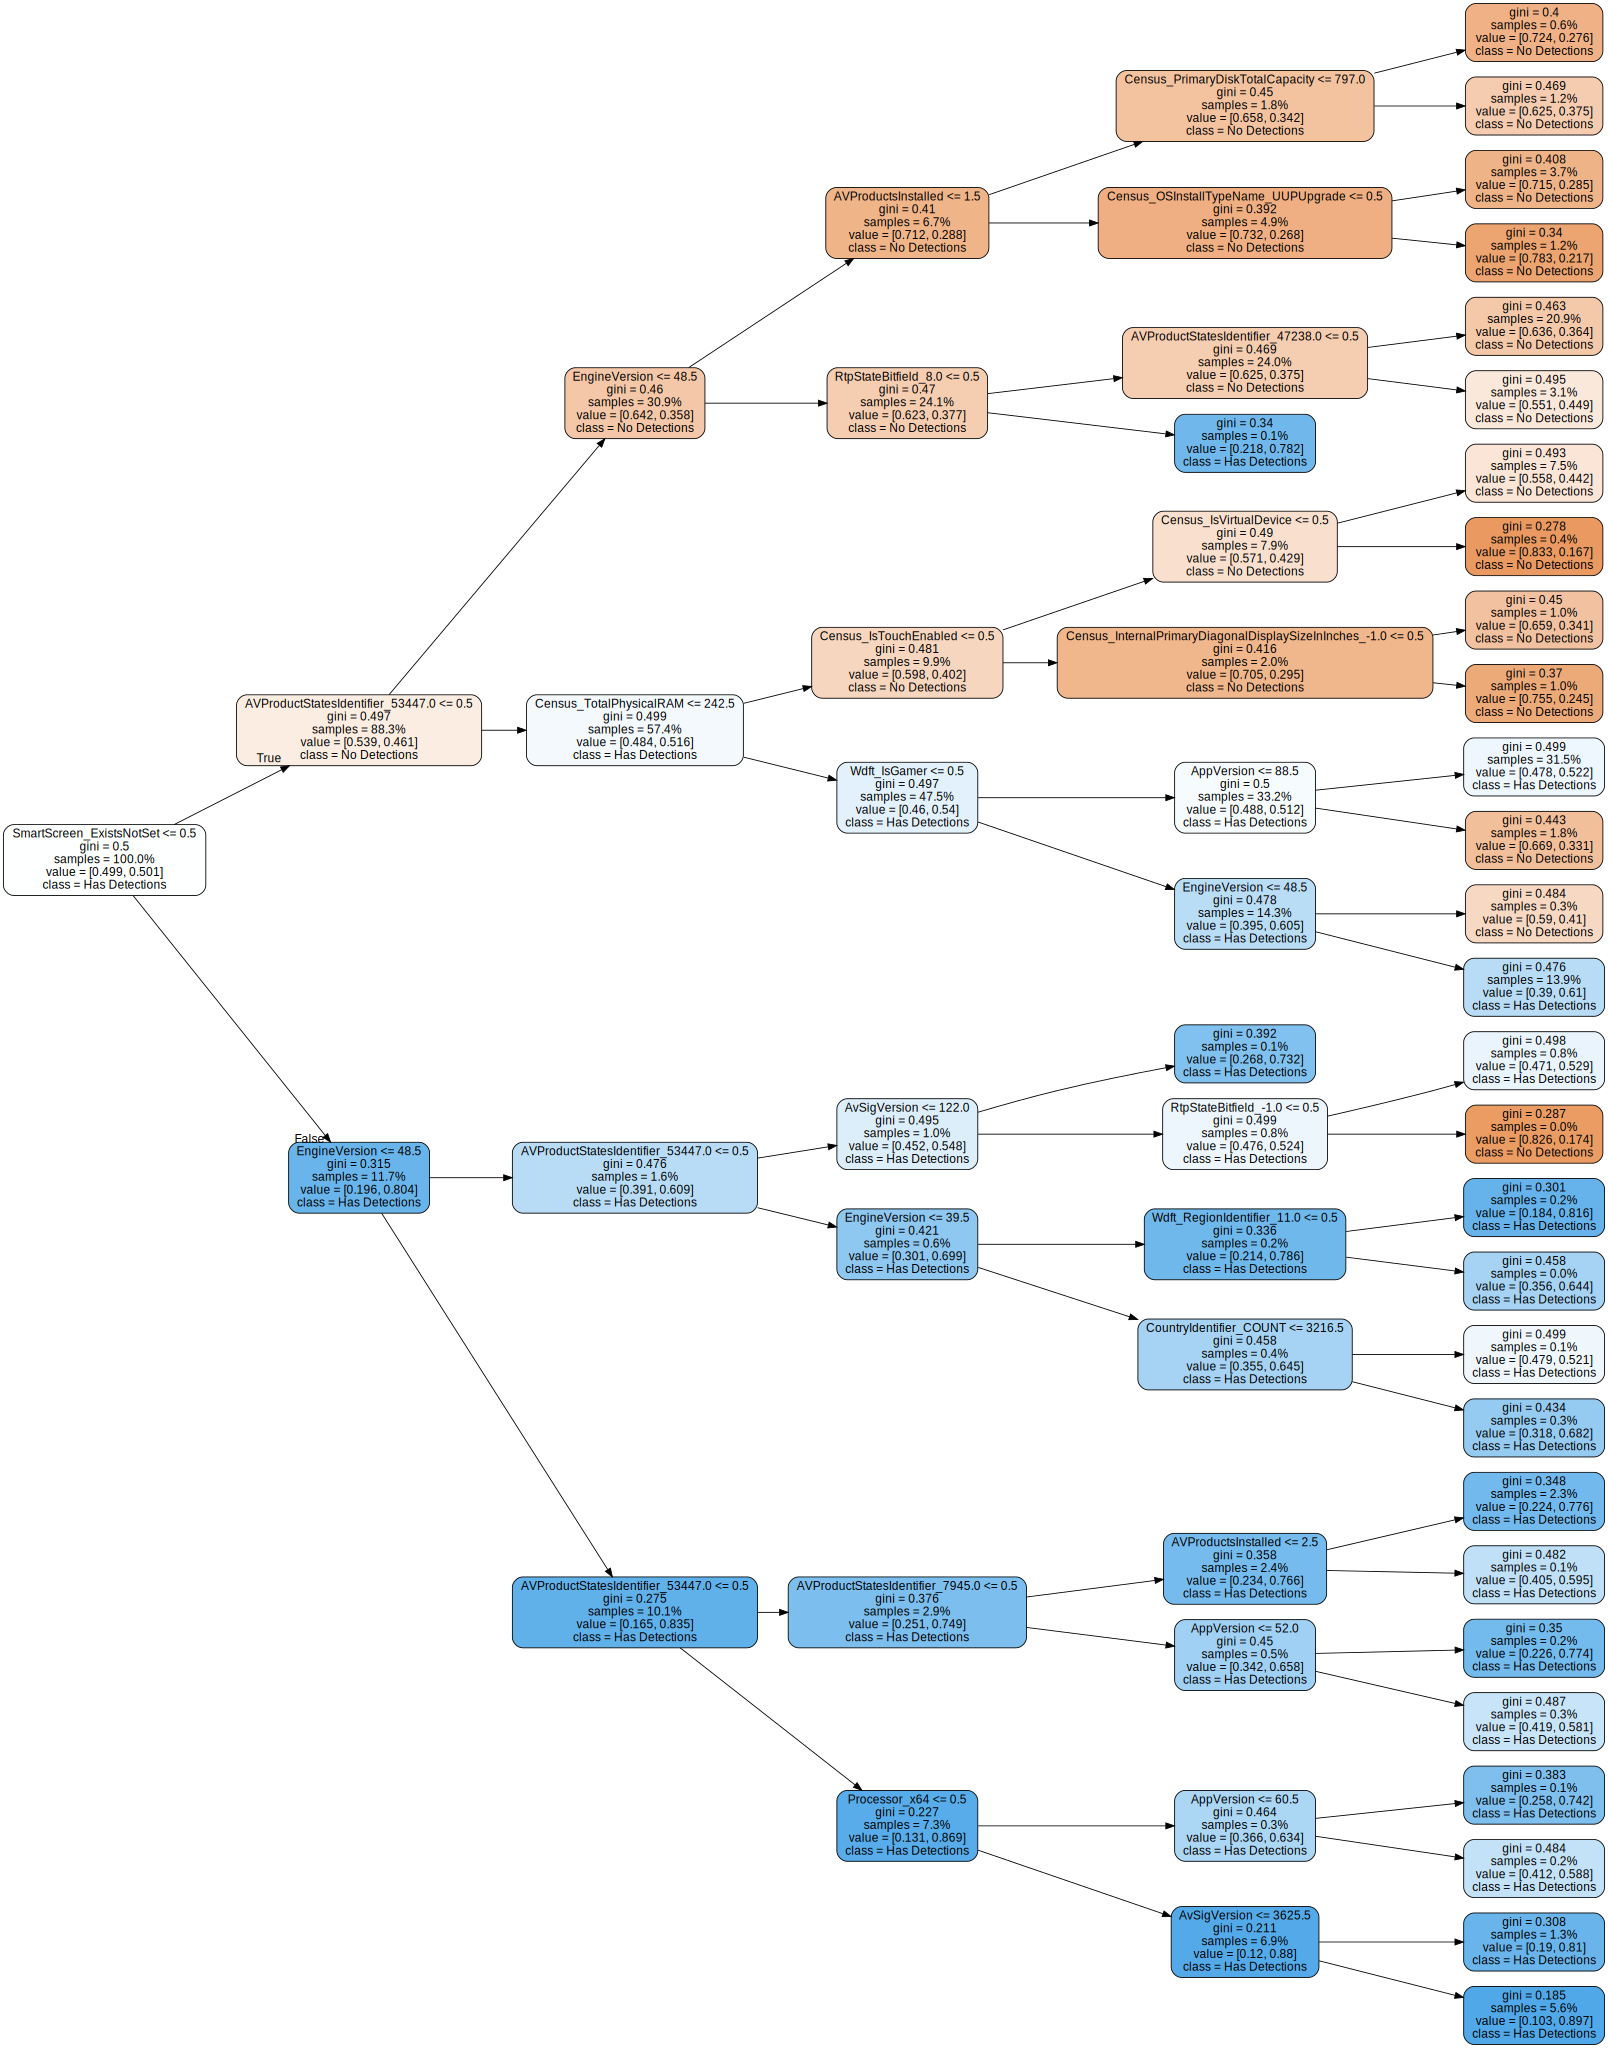

In [ ]:
# Graficamos el DT

graphviz.Source(text_tree)

De la lectura del árbol se ve que la variable más relevante es SmartScreen_ExistsNotSet . Cuando toma valores mayores a 0.5, la probabilidad de HasDetections pasa de un 50.1% a un 80.4%, y esto aplica para el 11.7% de los ejemplos.
Tambien podemos ver que el Gini allí es más alto, lo que indica que hay menor pureza, por lo cual hay menor probabilidad de homogeneidad de los nodos.

#### 4.3 - Optimización de modelos

In [ ]:
# Calculamos la predicción

y_test_pred = pd.DataFrame(dt.predict(X_test), index = y_test.index, columns = ['Malware Predictions'])

Confusion Matrix:
[[0.68805458 0.31194542]
 [0.45607077 0.54392923]]


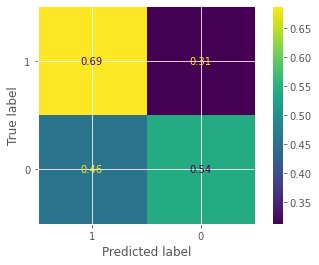

In [ ]:
#confusion matrix
print('Confusion Matrix:')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred, labels=[1, 0], normalize="true")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()

Como tenemos un dataset muy balanceado podemos usar el accuracy, sin necesidad de entrar en más detalle.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)

0.6156133333333333

#### 5.1 - Optimización de hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

cv = 2
def optimizar_params(clf, tuned_parameters, scores, cv):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            clf, tuned_parameters, scoring=score, cv=cv
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        
        #confusion matrix
        print('Confusion Matrix:')
        from sklearn.metrics import confusion_matrix
        
        cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
        print(cm)

        return clf.best_params_

In [ ]:
tuned_parameters = [{
                      "criterion": ["gini"],
                      "max_depth": [10, 15, 20], #cantidad de preguntas que permitimos
                      "min_samples_split": [0.10, 0.05, 0.03,0.01], #cantidad minima de obs en corte
                      "random_state": [42],
                     }]

scores = ["accuracy"]

clf = DecisionTreeClassifier()
optimizar_params(clf, tuned_parameters, scores, cv)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 0.01, 'random_state': 42}

Grid scores on development set:

0.621 (+/-0.005) for {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 0.1, 'random_state': 42}
0.623 (+/-0.002) for {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 0.05, 'random_state': 42}
0.624 (+/-0.003) for {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 0.03, 'random_state': 42}
0.626 (+/-0.002) for {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 0.01, 'random_state': 42}
0.622 (+/-0.005) for {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 0.1, 'random_state': 42}
0.625 (+/-0.002) for {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 0.05, 'random_state': 42}
0.626 (+/-0.004) for {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 0.03, 'random_state': 42}
0.628 (+/-0.002) for {'criterion': 'gini', 'ma

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 0.01,
 'random_state': 42}

#### 5.2 - Recalibrado

In [ ]:
# Instanciamos el modelo
dt_final = DecisionTreeClassifier(criterion="gini",
                      max_depth= 15, #cantidad de preguntas que permitimos
                      min_samples_split= 0.01, #cantidad minima de obs en corte
                      random_state= 42)

In [ ]:
#Entrenamos el modelo
dt_final.fit(
    X_train, y_train
)

DecisionTreeClassifier(max_depth=15, min_samples_split=0.01, random_state=42)

In [ ]:
# Calculamos la predicción

y_test_pred_final = pd.DataFrame(dt_final.predict(X_test), index = y_test.index, columns = ['Malware Predictions'])

In [ ]:
dt_final.score(X_test, y_test)

0.6319733333333334

##### Prueba de diversas estrategias de validación

###### Vemos que nuestro mejor modelo de DT comienza a hacer OverFitting luego de la pregunta número 8, vamos a crear la versión final del mismo con este valor

In [ ]:
for i in range(1, 20):
    dt_final = DecisionTreeClassifier(max_depth=i, random_state=42)
    dt_final.fit(X_train, y_train)
    train_accuracy = dt_final.score(X_train, y_train)
    test_accuracy = dt_final.score(X_test, y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.5702771428571428 - Test: 0.5745533333333334
Profundidad del árbol: 2. Train: 0.5887085714285715 - Test: 0.58846
Profundidad del árbol: 3. Train: 0.6081057142857142 - Test: 0.6081333333333333
Profundidad del árbol: 4. Train: 0.6089514285714286 - Test: 0.6089733333333334
Profundidad del árbol: 5. Train: 0.6156285714285714 - Test: 0.6156133333333333
Profundidad del árbol: 6. Train: 0.6189657142857142 - Test: 0.6193
Profundidad del árbol: 7. Train: 0.6210085714285715 - Test: 0.6200666666666667
Profundidad del árbol: 8. Train: 0.6251457142857143 - Test: 0.6236133333333334
Profundidad del árbol: 9. Train: 0.6319428571428571 - Test: 0.6271866666666667
Profundidad del árbol: 10. Train: 0.6375371428571428 - Test: 0.62886
Profundidad del árbol: 11. Train: 0.64366 - Test: 0.6293733333333333
Profundidad del árbol: 12. Train: 0.6492228571428571 - Test: 0.6289
Profundidad del árbol: 13. Train: 0.6565285714285715 - Test: 0.6289333333333333
Profundidad del árbol: 14.

In [ ]:
# Instanciamos el modelo
dt_final2 = DecisionTreeClassifier(criterion="gini",
                      max_depth= 8, #cantidad de preguntas que permitimos
                      min_samples_split= 0.01, #cantidad minima de obs en corte
                      random_state= 42)

In [ ]:
#Entrenamos el modelo
dt_final2.fit(
    X_train, y_train
)

DecisionTreeClassifier(max_depth=8, min_samples_split=0.01, random_state=42)

In [ ]:
# Calculamos la predicción

y_test_pred_final = pd.DataFrame(dt_final2.predict(X_test), index = y_test.index, columns = ['Malware Predictions'])

In [ ]:
dt_final2.score(X_test, y_test)

0.6233133333333334